# Building Machine Learning Systems That Don't Suck


This notebook creates a [SageMaker Pipeline](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html) to build an end-to-end Machine Learning system to solve the problem of classifying penguin species. With a SageMaker Pipeline, you can create, automate, and manage end-to-end Machine Learning workflows at scale.

You can find more information about Amazon SageMaker in the [Amazon SageMaker Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html). The [AWS Machine Learning Blog](https://aws.amazon.com/blogs/machine-learning/) is an excellent source to stay up-to-date with SageMaker.

This example uses the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data).

<img src='images/penguins.png' alt='Penguins' width="800">

This notebook is part of the [Machine Learning School](https://www.ml.school) program.


## Session 1 - Introduction and Initial Setup

The machine learning system we'll build during this program consists of four main pipelines: A **training** pipeline, an **inference** pipeline, a **deployment** pipeline, and a **monitoring** pipeline.

Here is an architectural diagram showing how the system is structured:

<a href="images/diagram.png" target="_blank"> <img src="images/diagram.png" alt="SageMaker architectural diagram of the system" style="max-width: 740px;" /></a>

Throughout the sessions, we'll build each of these pipelines. We'll also build variations to show you different alternatives and best practices.

Let's start by setting up the environment and preparing to run the notebook.


In [32]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import json
import logging
import sys
from pathlib import Path
import warnings

import ipytest

CODE_FOLDER = Path("code")
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


We can run this notebook in [Local Mode](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-local-mode.html) to test some of the system components in your local environment. Unfortunately, not every component is supported in Local Mode.

Setting the `LOCAL_MODE` variable to `True` will run every supported pipeline component locally. Setting the variable to `False` will run the pipeline in SageMaker.


In [33]:
class Configuration:

    def __init__(self, local_mode: bool = True, bucket: str = None, is_arm64: bool = True, aws_instance_type: str = "ml.m5.xlarge"):
        self.instance_type = "local" if local_mode else aws_instance_type
        self.bucket = bucket
        self.is_arm64 = is_arm64

    def load(self) -> dict:
        from sagemaker.workflow.pipeline_context import (
            LocalPipelineSession,
            PipelineSession,
        )

        config = {
            "session": LocalPipelineSession(default_bucket=self.bucket) if self.instance_type == "local" else PipelineSession(default_bucket=self.bucket),
            "instance_type": self.instance_type,
            "image": "sagemaker-tensorflow-toolkit-local" if self.is_arm64 else None,
            "framework_version": "2.12",
            "py_version": "py310"
            }
        return config

If you are running the pipeline in Local Mode on an ARM64 machine (for example, on Apple Silicon), you will need to use a custom Docker image to train and evaluate the model. Let's create a variable indicating if we are running on an ARM64 machine.


In [34]:
# We can retrieve the architecture of the local
# computer using the `uname -m` command.
architecture = !(uname -m)

IS_ARM64_ARCHITECTURE = architecture[0] == "arm64"

Let's now load the environment variables we need to run the notebook.


In [35]:
import os


BUCKET = os.environ["AWS_BUCKET"]
ROLE = os.environ["AWS_ROLE"]

COMET_API_KEY = os.environ.get("COMET_API_KEY", None)
COMET_PROJECT_NAME = os.environ.get("COMET_PROJECT_NAME", None)

config = Configuration(local_mode=True, bucket=BUCKET, is_arm64=IS_ARM64_ARCHITECTURE).load()

Let's create a configuration dictionary with different settings depending on whether we are running the pipeline in Local Mode. We'll use this dictionary to configure the pipeline components.


In [36]:
# import sagemaker
# from sagemaker.workflow.pipeline_context import LocalPipelineSession, PipelineSession

# pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

# if LOCAL_MODE:
#     config = {
#         "session": LocalPipelineSession(default_bucket=bucket),
#         "instance_type": "local",
#         # We need to use a custom Docker image when we run the pipeline
#         # in Local Model on an ARM64 machine.
#         "image": (
#             "sagemaker-tensorflow-toolkit-local" if IS_ARM64_ARCHITECTURE else None
#         ),
#     }
# else:
#     config = {
#         "session": pipeline_session,
#         "instance_type": "ml.m5.xlarge",
#         "image": None,
#     }

# # These specific settings refer to the SageMaker
# # TensorFlow container we'll use.
# config["framework_version"] = "2.12"
# config["py_version"] = "py310"

Let's now initialize a few variables that we'll need throughout the notebook:


In [37]:
import boto3
import sagemaker

S3_LOCATION = f"s3://{BUCKET}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

## Session 2 - Exploratory Data Analysis

Let's run Exploratory Data Analysis on the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data). The goal of this session is to understand the data and the problem we are trying to solve.


Let's load the Penguins dataset:


In [38]:
import numpy as np
import pandas as pd

penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


We can see the dataset contains the following columns:

1. `species`: The species of a penguin. This is the column we want to predict.
2. `island`: The island where the penguin was found
3. `culmen_length_mm`: The length of the penguin's culmen (bill) in millimeters
4. `culmen_depth_mm`: The depth of the penguin's culmen in millimeters
5. `flipper_length_mm`: The length of the penguin's flipper in millimeters
6. `body_mass_g`: The body mass of the penguin in grams
7. `sex`: The sex of the penguin

If you are curious, here is the description of a penguin's culmen:

<img src='images/culmen.jpeg' alt='Culmen' width="600">


Now, let's get the summary statistics for the features in our dataset.


In [39]:
penguins.describe(include="all")

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


Let's now display the distribution of values for the three categorical columns in our data:


In [40]:
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution, end="\n\n")
print(island_distribution, end="\n\n")
print(sex_distribution)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


The distribution of the categories in our data are:

-   `species`: There are 3 species of penguins in the dataset: Adelie (`152`), Gentoo (`124`), and Chinstrap (`68`).
-   `island`: Penguins are from 3 islands: Biscoe (`168`), Dream (`124`), and Torgersen (`52`).
-   `sex`: We have `168` male penguins, `165` female penguins, and `1` penguin with an ambiguous gender (`.`).

Let's replace the ambiguous value in the `sex` column with a `null` value:


In [41]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)

# Let's display the new distribution of the column:
sex_distribution = penguins["sex"].value_counts()
sex_distribution

sex
MALE      168
FEMALE    165
Name: count, dtype: int64

Next, let's check for any missing values in the dataset.


In [42]:
penguins.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let's get rid of the missing values. For now, we are going to replace the missing values with the most frequent value in the column. Later, we'll use a different strategy to replace missing numeric values.


In [43]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:, :] = imputer.fit_transform(penguins)

# Let's display again the number of missing values:
penguins.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Let's visualize the distribution of categorical features.


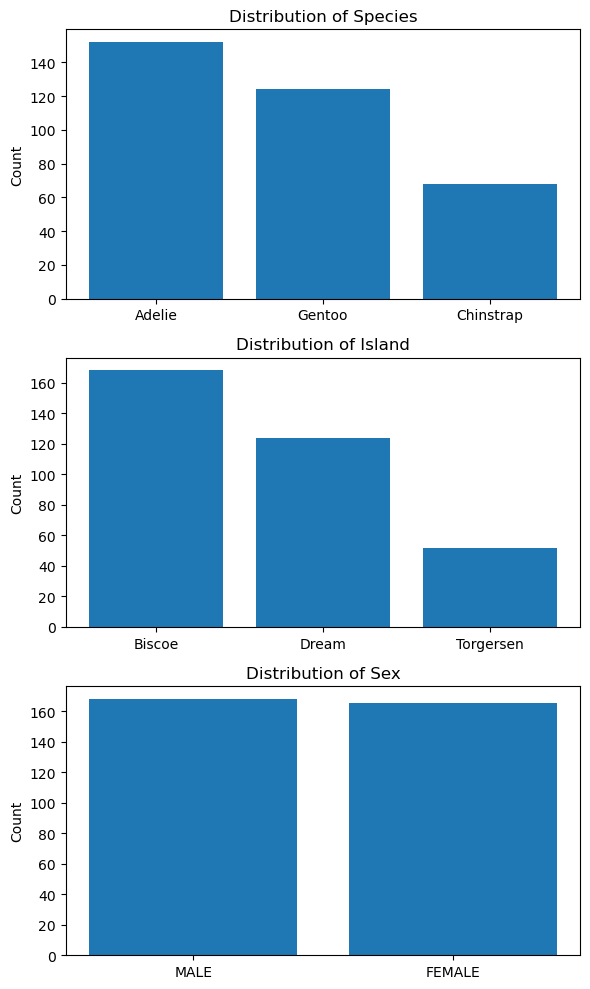

In [44]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()

Let's visualize the distribution of numerical columns.


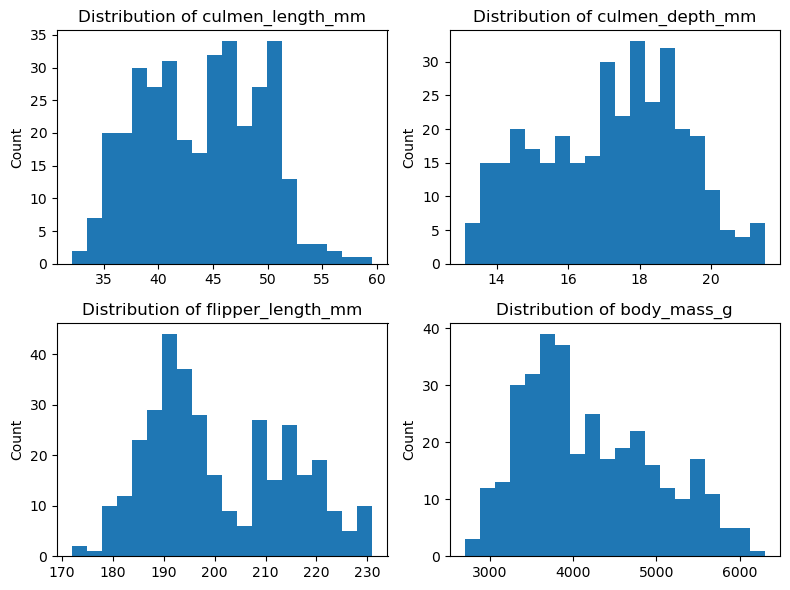

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(penguins["culmen_length_mm"], bins=20)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of culmen_length_mm")

axs[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of culmen_depth_mm")

axs[1, 0].hist(penguins["flipper_length_mm"], bins=20)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of flipper_length_mm")

axs[1, 1].hist(penguins["body_mass_g"], bins=20)
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Distribution of body_mass_g")

plt.tight_layout()
plt.show()

Let's display the covariance matrix of the dataset. The "covariance" measures how changes in one variable are associated with changes in a second variable. In other words, the covariance measures the degree to which two variables are linearly associated.


In [46]:
penguins.cov(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


Here are three examples of what we get from interpreting the covariance matrix below:

1. The positive covariance of 50.26 between culmen length and flippler length suggests that larger values of culmen length are associated with larger values of flipper length. As one increases, generally so does the other.
2. The positive covariance of 2596.97 between culmen length and body mass suggests that heavier penguins generally have longer culmens. There is a tendency for these two variables to increase together.
3. The negative covariance of -742.66 between culmen depth and body mass suggests a general tendency that penguins with deeper culmens weigh less.


Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables:


In [47]:
penguins.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


Here are three examples of what we get from interpreting the correlation matrix below:

1. Penguins that weight more tend to have longer flippers.
2. Penguins with a shallower culmen tend to have longer flippers.
3. Penguins with longer culmens tend to have longer flippers.


Let's display the distribution of species by island:


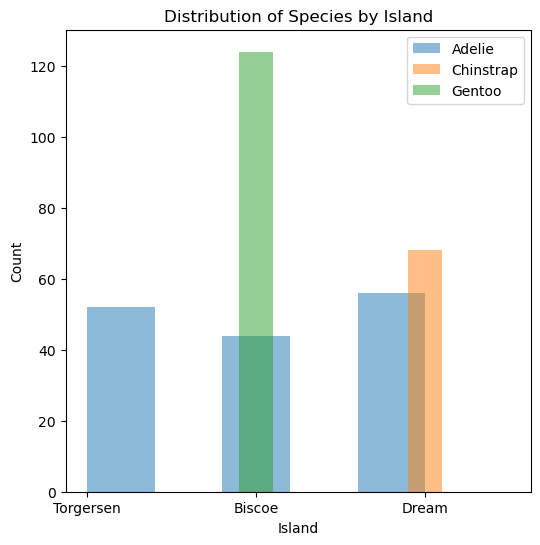

In [48]:
unique_species = penguins["species"].unique()

fig, ax = plt.subplots(figsize=(6, 6))
for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["island"], bins=5, alpha=0.5, label=species)

ax.set_xlabel("Island")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Island")
ax.legend()
plt.show()

Let's display the distribution of species by sex.


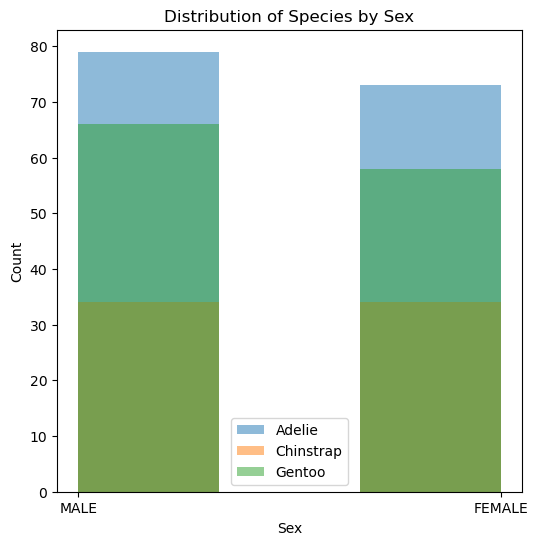

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))

for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["sex"], bins=3, alpha=0.5, label=species)

ax.set_xlabel("Sex")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Sex")

ax.legend()
plt.show()

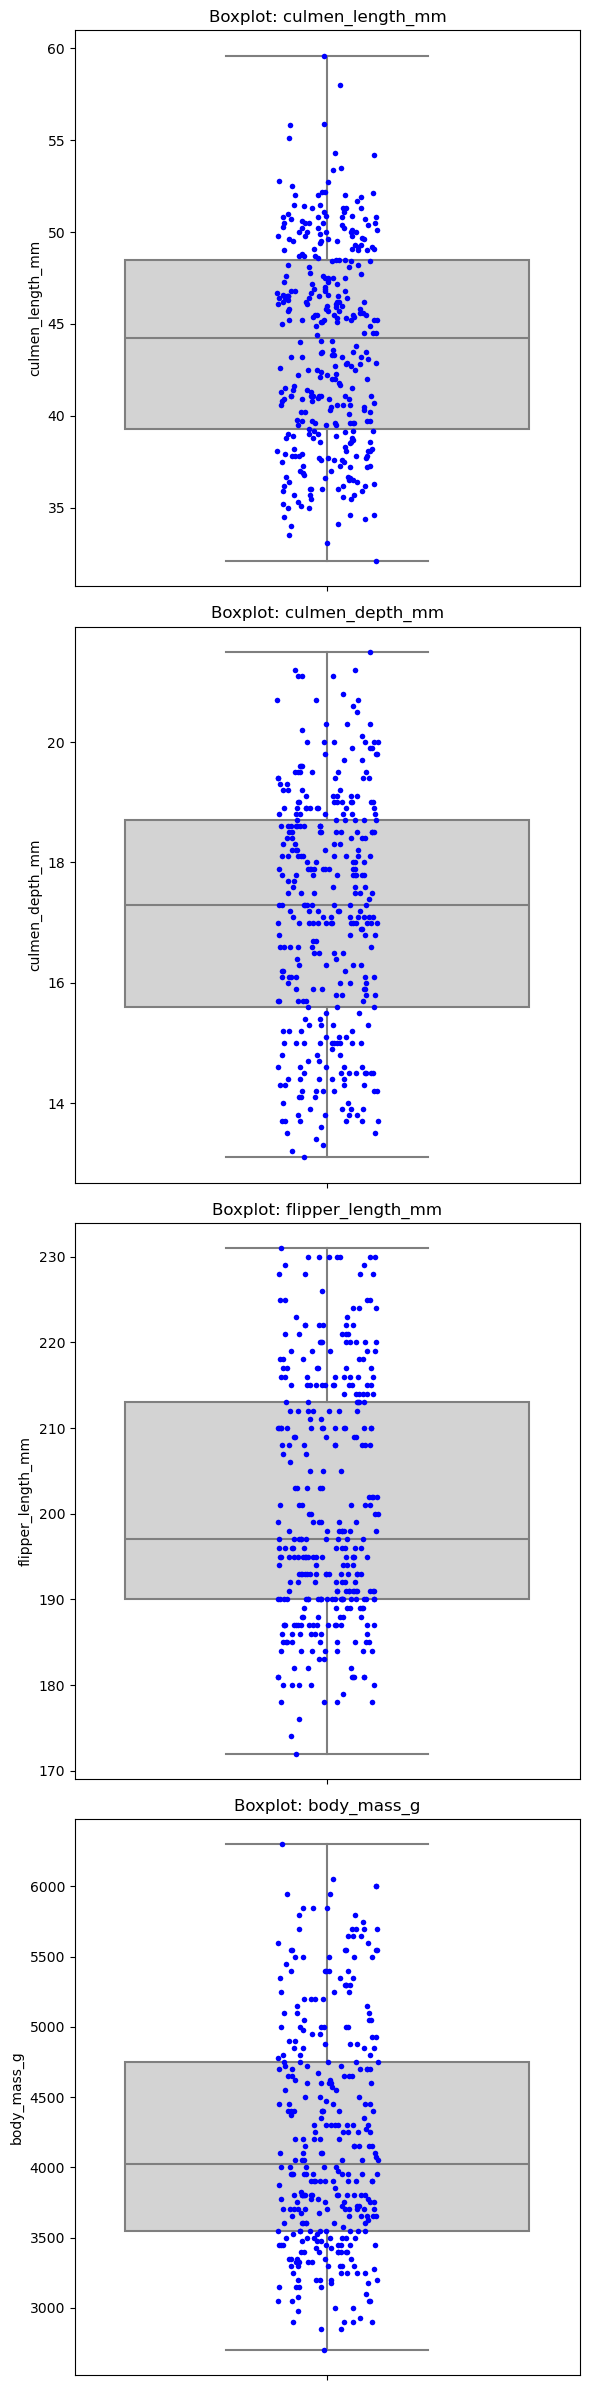

In [52]:
# Assignments

# 1. Identify potential outliers
import seaborn as sns

num_cols = penguins.select_dtypes(include="number").columns
fig, axs = plt.subplots(len(num_cols), figsize=(6, 6*len(num_cols)))

# Iterate over each numeric column and each subplot axis
for ax, col in zip(axs, num_cols):
    sns.boxplot(y=penguins[col], ax=ax, color='lightgray')
    sns.stripplot(y=penguins[col], ax=ax, color='blue', size=4)
    ax.set_title(f"Boxplot: {col}")

# Display the figure with all subplots
plt.tight_layout()
plt.show()

# 2. Determine if 'sex' has predictive power for 'species' column
# 3. Visualize / quantify predictive strength of every feature

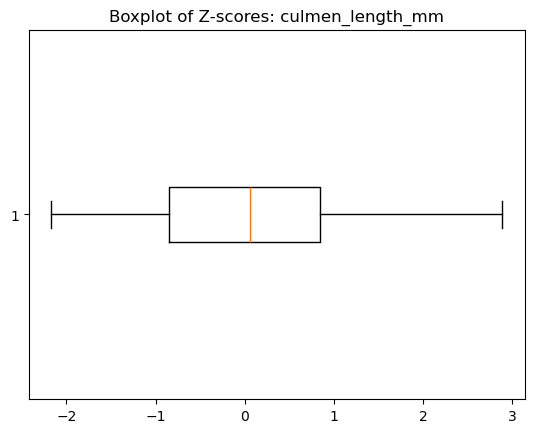

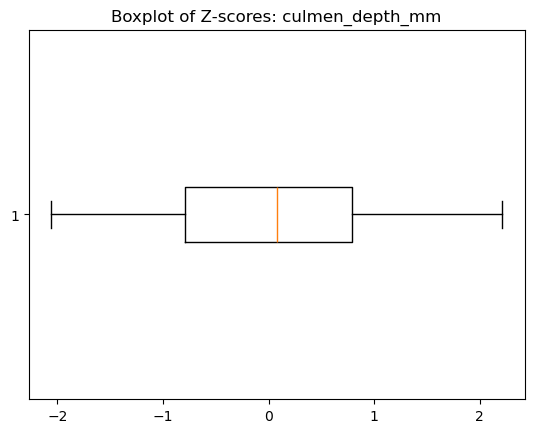

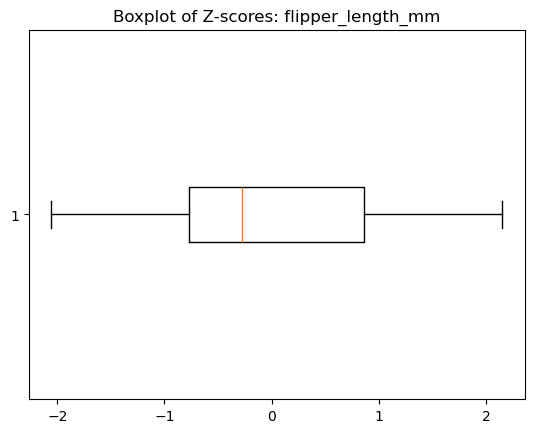

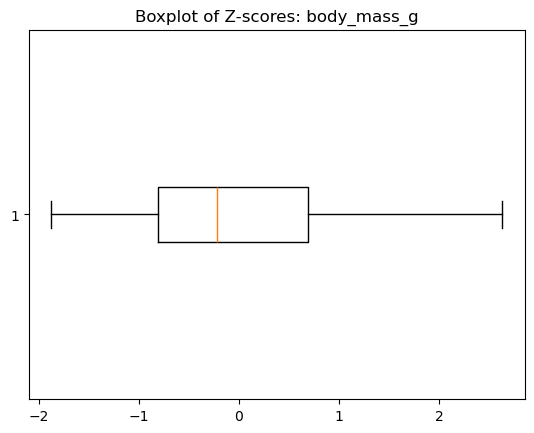

In [53]:
from scipy import stats

# Assuming df is your DataFrame
for col in num_cols:
    # Calculate Z-scores
    z_scores = stats.zscore(penguins[col])

    # Create a new figure
    plt.figure()

    # Create a boxplot of the Z-scores
    plt.boxplot(z_scores, vert=False)

    # Set the title
    plt.title(f"Boxplot of Z-scores: {col}")

    # Show the plot
    plt.show()

## Session 3 - Splitting and Transforming the Data

In this session we'll build a simple [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with one step to split and transform the data:

<a href="images/processing-step.png" target="_blank"> <img src="images/processing-step.png" alt="High-level overview of the Preprocessing Step" style="max-width: 740px;" /></a>

We'll use a [Scikit-Learn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for the transformations, and a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) with a [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) to execute a preprocessing script. Check the [SageMaker Pipelines Overview](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) for an introduction to the fundamental components of a SageMaker Pipeline.


### Step 1 - Creating the Preprocessing Script

The first step we need in the pipeline is a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) to run a script that will split and transform the data.

This Processing Step will create a SageMaker Processing Job in the background, run the script, and upload the output to S3. You can use Processing Jobs to perform data preprocessing, post-processing, feature engineering, data validation, and model evaluation. Check the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) SageMaker's SDK documentation for more information.


We will store the script in a folder called `processing` and add it to the system path so we can later import it as a module.


In [ ]:
(CODE_FOLDER / "processing").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/processing"])

Let's now create the script:


In [ ]:
%%writefile {CODE_FOLDER}/processing/script.py
# | filename: script.py
# | code-line-numbers: true

import os
import tarfile
import tempfile
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


def preprocess(base_directory):
    """Load the supplied data, split it and transform it."""
    df = _read_data_from_input_csv_files(base_directory)

    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])],
    )

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler(),
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(),
    )

    features_transformer = ColumnTransformer(
        transformers=[
            (
                "numeric",
                numeric_transformer,
                make_column_selector(dtype_exclude="object"),
            ),
            ("categorical", categorical_transformer, ["island"]),
        ],
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_train_baseline(base_directory, df_train)
    _save_test_baseline(base_directory, df_test)

    y_train = target_transformer.fit_transform(
        np.array(df_train.species.values).reshape(-1, 1),
    )
    y_validation = target_transformer.transform(
        np.array(df_validation.species.values).reshape(-1, 1),
    )
    y_test = target_transformer.transform(
        np.array(df_test.species.values).reshape(-1, 1),
    )

    df_train = df_train.drop("species", axis=1)
    df_validation = df_validation.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    X_train = features_transformer.fit_transform(df_train)  # noqa: N806
    X_validation = features_transformer.transform(df_validation)  # noqa: N806
    X_test = features_transformer.transform(df_test)  # noqa: N806

    _save_splits(
        base_directory,
        X_train,
        y_train,
        X_validation,
        y_validation,
        X_test,
        y_test,
    )
    _save_model(base_directory, target_transformer, features_transformer)


def _read_data_from_input_csv_files(base_directory):
    """Read the data from the input CSV files.

    This function reads every CSV file available and
    concatenates them into a single dataframe.
    """
    input_directory = Path(base_directory) / "input"
    files = list(input_directory.glob("*.csv"))

    if len(files) == 0:
        message = f"The are no CSV files in {input_directory.as_posix()}/"
        raise ValueError(message)

    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)

    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """Split the data into train, validation, and test."""
    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_train_baseline(base_directory, df_train):
    """Save the untransformed training data to disk.

    We will need the training data to compute a baseline to
    determine the quality of the data that the model receives
    when deployed.
    """
    baseline_path = Path(base_directory) / "train-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_train.copy().dropna()

    # To compute the data quality baseline, we don't need the
    # target variable, so we'll drop it from the dataframe.
    df = df.drop("species", axis=1)

    df.to_csv(baseline_path / "train-baseline.csv", header=True, index=False)


def _save_test_baseline(base_directory, df_test):
    """Save the untransformed test data to disk.

    We will need the test data to compute a baseline to
    determine the quality of the model predictions when deployed.
    """
    baseline_path = Path(base_directory) / "test-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_test.copy().dropna()

    # We'll use the test baseline to generate predictions later,
    # and we can't have a header line because the model won't be
    # able to make a prediction for it.
    df.to_csv(baseline_path / "test-baseline.csv", header=False, index=False)


def _save_splits(
    base_directory,
    X_train,  # noqa: N803
    y_train,
    X_validation,  # noqa: N803
    y_validation,
    X_test,  # noqa: N803
    y_test,
):
    """Save data splits to disk.

    This function concatenates the transformed features
    and the target variable, and saves each one of the split
    sets to disk.
    """
    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        validation_path / "validation.csv",
        header=False,
        index=False,
    )
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """Save the Scikit-Learn transformation pipelines.

    This function creates a model.tar.gz file that
    contains the two transformation pipelines we built
    to transform the data.
    """
    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, Path(directory) / "target.joblib")
        joblib.dump(features_transformer, Path(directory) / "features.joblib")

        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)

        with tarfile.open(f"{(model_path / 'model.tar.gz').as_posix()}", "w:gz") as tar:
            tar.add(Path(directory) / "target.joblib", arcname="target.joblib")
            tar.add(
                Path(directory) / "features.joblib", arcname="features.joblib",
            )


if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Let's test the script to ensure everything is working as expected:


In [ ]:
%%ipytest -s
# | code-fold: true

import os
import shutil
import tarfile
import tempfile

import pytest
from processing.script import preprocess


@pytest.fixture(autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)
    preprocess(base_directory=directory)

    yield directory

    shutil.rmtree(directory)


def test_preprocess_generates_data_splits(directory):
    output_directories = os.listdir(directory)

    assert "train" in output_directories
    assert "validation" in output_directories
    assert "test" in output_directories


def test_preprocess_generates_baselines(directory):
    output_directories = os.listdir(directory)

    assert "train-baseline" in output_directories
    assert "test-baseline" in output_directories


def test_preprocess_creates_two_models(directory):
    model_path = directory / "model"
    tar = tarfile.open(model_path / "model.tar.gz", "r:gz")

    assert "features.joblib" in tar.getnames()
    assert "target.joblib" in tar.getnames()


def test_splits_are_transformed(directory):
    train = pd.read_csv(directory / "train" / "train.csv", header=None)
    validation = pd.read_csv(directory / "validation" / "validation.csv", header=None)
    test = pd.read_csv(directory / "test" / "test.csv", header=None)

    # After transforming the data, the number of features should be 7:
    # * 3 - island (one-hot encoded)
    # * 1 - culmen_length_mm = 1
    # * 1 - culmen_depth_mm
    # * 1 - flipper_length_mm
    # * 1 - body_mass_g
    number_of_features = 7

    # The transformed splits should have an additional column for the target
    # variable.
    assert train.shape[1] == number_of_features + 1
    assert validation.shape[1] == number_of_features + 1
    assert test.shape[1] == number_of_features + 1


def test_train_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "train-baseline" / "train-baseline.csv",
        header=None,
    )

    island = baseline.iloc[:, 0].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_test_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "test-baseline" / "test-baseline.csv", header=None
    )

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_train_baseline_includes_header(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv")
    assert baseline.columns[0] == "island"


def test_test_baseline_does_not_include_header(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv")
    assert baseline.columns[0] != "island"

### Step 2 - Caching Configuration

Several SageMaker Pipeline steps support caching. When a step runs, and dependending on the configured caching policy, SageMaker will try to reuse the result of a previous successful run of the same step. You can find more information about this topic in [Caching Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-caching.html).

Let's define a caching policy that we'll reuse on every step:


In [ ]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="15d")

### Step 3 - Pipeline Configuration

We can parameterize a SageMaker Pipeline to make it more flexible. In this case, we'll use a parameter to pass the location of the dataset we want to process. We can execute the pipeline with different datasets by changing the value of this parameter. Check [Pipeline Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html) for more information.


In [ ]:
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)

### Step 4 - Setting up the Processing Step

Let's now define the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) that we'll use in the pipeline to run the script that will split and transform the data.

A processor gives the Processing Step information about the hardware and software that SageMaker should use to launch a Processing Job. To run the script we created, we need access to Scikit-Learn, so we can use the [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) processor that comes out-of-the-box with the SageMaker's Python SDK.

SageMaker manages the infrastructure of a Processing Job. It provisions resources for the duration of the job, and cleans up when it completes. The Processing Container image that SageMaker uses to run a Processing Job can either be a SageMaker built-in image or a custom image:

<a href="images/processing-job.png" target="_blank"> <img src="images/processing-job.png" alt="High-level overview of a SageMaker Processing Job" style="max-width: 740px;" /></a>

The [Data Processing with Framework Processors](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) page discusses other built-in processors you can use. The [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) page contains information about the available framework versions for each region.


In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    # By default, a new account doesn't have access to `ml.m5.xlarge` instances.
    # If you haven't requested a quota increase yet, you can use an
    # `ml.t3.medium` instance type instead. This will work out of the box, but
    # the Processing Job will take significantly longer than it should have.
    # To get access to `ml.m5.xlarge` instances, you can request a quota
    # increase under the Service Quotas section in your AWS account.
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

Let's now define the Processing Step that we'll use in the pipeline.

This step will specify the list of inputs that we'll access from the preprocessing script. In this case, the input is the dataset we stored in S3. We also have a few outputs that we want SageMaker to capture when the Processing Job finishes.


In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{(CODE_FOLDER / 'processing' / 'script.py').as_posix()}",
        inputs=[
            ProcessingInput(
                source=dataset_location,
                destination="/opt/ml/processing/input",
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="validation",
                source="/opt/ml/processing/validation",
                destination=f"{S3_LOCATION}/preprocessing/validation",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

### Step 5 - Creating the Pipeline

We can now create the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
from sagemaker.workflow.pipeline import Pipeline

session3_pipeline = Pipeline(
    name="session3-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session3_pipeline.upsert(role_arn=role)

## Session 4 - Training the Model

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a [step to train a model](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training). Check [Train a Model with TensorFlow](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#train-a-model-with-tensorflow) for more information about training a model with TensorFlow.

<a href="images/training-step.png" target="_blank"> <img src="images/training-step.png" alt="High-level overview of the Training Step" style="max-width: 740px;" /></a>

We'll also introduce experiment tracking using [Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) and [Comet](https://www.comet.com/site/?utm_source=svpino_course&utm_medium=partner&utm_content=github).


### Step 1 - Creating the Training Script

Let's create the training script. This script is responsible for training a neural network using the train data, validating the model, and saving it so we can later use it.


We will store the script in a folder called `training` and add it to the system path so we can later import it as a module.


In [ ]:
(CODE_FOLDER / "training").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/training"])

We can now create the script inside the folder:


In [ ]:
%%writefile {CODE_FOLDER}/training/script.py
# | filename: script.py
# | code-line-numbers: true

import argparse
import json
import os
import tarfile
from pathlib import Path

import keras
import numpy as np
import pandas as pd
from comet_ml import Experiment
from keras import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from packaging import version
from sklearn.metrics import accuracy_score


def train(
    model_directory,
    train_path,
    validation_path,
    pipeline_path,
    experiment,
    epochs=50,
    batch_size=32,
):
    print(f"Keras version: {keras.__version__}")

    X_train = pd.read_csv(Path(train_path) / "train.csv")
    y_train = X_train[X_train.columns[-1]]
    X_train = X_train.drop(X_train.columns[-1], axis=1)

    X_validation = pd.read_csv(Path(validation_path) / "validation.csv")
    y_validation = X_validation[X_validation.columns[-1]]
    X_validation = X_validation.drop(X_validation.columns[-1], axis=1)

    model = Sequential(
        [
            Input(shape=(X_train.shape[1],)),
            Dense(10, activation="relu"),
            Dense(8, activation="relu"),
            Dense(3, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.fit(
        X_train,
        y_train,
        validation_data=(X_validation, y_validation),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
    )

    predictions = np.argmax(model.predict(X_validation), axis=-1)
    val_accuracy = accuracy_score(y_validation, predictions)
    print(f"Validation accuracy: {val_accuracy}")

    # Starting on version 3, Keras changed the model saving format.
    # Since we are running the training script using two different versions
    # of Keras, we need to check to see which version we are using and save
    # the model accordingly.
    model_filepath = (
        Path(model_directory) / "001"
        if version.parse(keras.__version__) < version.parse("3")
        else Path(model_directory) / "penguins.keras"
    )

    model.save(model_filepath)

    # Let's save the transformation pipelines inside the
    # model directory so they get bundled together.
    with tarfile.open(Path(pipeline_path) / "model.tar.gz", "r:gz") as tar:
        tar.extractall(model_directory)

    if experiment:
        experiment.log_parameters(
            {
                "epochs": epochs,
                "batch_size": batch_size,
            }
        )
        experiment.log_dataset_hash(X_train)
        experiment.log_confusion_matrix(
            y_validation.astype(int), predictions.astype(int)
        )
        experiment.log_model("penguins", model_filepath.as_posix())


if __name__ == "__main__":
    # Any hyperparameters provided by the training job are passed to
    # the entry point as script arguments.
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=32)
    args, _ = parser.parse_known_args()

    # Let's create a Comet experiment to log the metrics and parameters
    # of this training job.
    comet_api_key = os.environ.get("COMET_API_KEY", None)
    comet_project_name = os.environ.get("COMET_PROJECT_NAME", None)

    experiment = (
        Experiment(
            project_name=comet_project_name,
            api_key=comet_api_key,
            auto_metric_logging=True,
            auto_param_logging=True,
            log_code=True,
        )
        if comet_api_key and comet_project_name
        else None
    )

    training_env = json.loads(os.environ.get("SM_TRAINING_ENV", {}))
    job_name = training_env.get("job_name", None) if training_env else None

    # We want to use the SageMaker's training job name as the name
    # of the experiment so we can easily recognize it.
    if job_name and experiment:
        experiment.set_name(job_name)

    train(
        # This is the location where we need to save our model.
        # SageMaker will create a model.tar.gz file with anything
        # inside this directory when the training script finishes.
        model_directory=os.environ["SM_MODEL_DIR"],
        # SageMaker creates one channel for each one of the inputs
        # to the Training Step.
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        validation_path=os.environ["SM_CHANNEL_VALIDATION"],
        pipeline_path=os.environ["SM_CHANNEL_PIPELINE"],
        experiment=experiment,
        epochs=args.epochs,
        batch_size=args.batch_size,
    )

Let's test the script to ensure everything is working as expected:


In [ ]:
%%ipytest -s
#| code-fold: true

import os
import shutil
import pytest
import tempfile

from processing.script import preprocess
from training.script import train

@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)

    preprocess(base_directory=directory)
    train(
        model_directory=directory / "model",
        train_path=directory / "train",
        validation_path=directory / "validation",
        pipeline_path=directory / "model",
        experiment=None,
        epochs=1
    )

    yield directory

    shutil.rmtree(directory)


def test_train_bundles_model_assets(directory):
    bundle = os.listdir(directory / "model")
    assert "001" in bundle

    assets = os.listdir(directory / "model" / "001")
    assert "saved_model.pb" in assets


def test_train_bundles_transformation_pipelines(directory):
    bundle = os.listdir(directory / "model")
    assert "target.joblib" in bundle
    assert "features.joblib" in bundle


### Step 2 - Setting up the Training Step

We can now create a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) that we can add to the pipeline. This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) SageMaker's SDK documentation for more information.

SageMaker manages the infrastructure of a Training Job. It provisions resources for the duration of the job, and cleans up when it completes. The Training Container image that SageMaker uses to run a Training Job can either be a SageMaker built-in image or a custom image.

<a href="images/training-job.png" target="_blank"> <img src="images/training-job.png" alt="High-level overview of a SageMaker Training Job" style="max-width: 740px;" /></a>

The [Available Deep Learning Container Images](https://github.com/aws/deep-learning-containers/blob/master/available_images.md) page contains the list of available containers for each region.


Our training script uses [Comet](https://www.comet.com/site/?utm_source=svpino_course&utm_medium=partner&utm_content=github) to track metrics from the Training Job. We need to create a `requirements.txt` file to install the Comet library in the training container.


In [ ]:
%%writefile {CODE_FOLDER}/training/requirements.txt
#| label: requirements.txt
#| filename: requirements.txt
#| code-line-numbers: false

comet_ml

SageMaker uses the concept of an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) to handle end-to-end training and deployment tasks. For this example, we will use the built-in [TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-estimator) to run the training script we wrote before.

Notice the list of hyperparameters defined below. SageMaker will pass these hyperparameters as arguments to the entry point of the training script.

We are going to use [Comet](https://www.comet.com/site/?utm_source=svpino_course&utm_medium=partner&utm_content=github) and [SageMaker Experiments](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html) to track metrics from the Training Job. SageMaker Experiments will use the list of metric definitions to decide which metrics to track and how to parse them from the Training Job logs. For more information, check [Manage Machine Learning with Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) and the [SageMaker Experiments' SDK documentation](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html).

Here are the environment variables we need to set on the traininng container:

-   `COMET_API_KEY`: This is your [Comet](https://www.comet.com/site/?utm_source=svpino_course&utm_medium=partner&utm_content=github) API key.
-   `COMET_PROJECT_NAME`: The name of the project where you want to track the experiments.


In [ ]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    base_job_name="training",
    entry_point="script.py",
    source_dir=f"{(CODE_FOLDER / 'training').as_posix()}",
    # SageMaker will pass these hyperparameters as arguments
    # to the entry point of the training script.
    hyperparameters={
        "epochs": 50,
        "batch_size": 32,
    },
    # SageMaker will create these environment variables on the
    # Training Job instance.
    environment={
        "COMET_API_KEY": COMET_API_KEY,
        "COMET_PROJECT_NAME": COMET_PROJECT_NAME,
    },
    # SageMaker will track these metrics as part of the experiment
    # associated to this pipeline. The metric definitions tells
    # SageMaker how to parse the values from the Training Job logs.
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    disable_profiler=True,
    debugger_hook_config=False,
    sagemaker_session=config["session"],
    role=role,
)

We can now create a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training). This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) SageMaker's SDK documentation for more information.

This step will receive the train and validation split from the preprocessing step as inputs.

Here, we are using three input channels, `train`, `validation`, and `pipeline`. SageMaker will automatically create an environment variable corresponding to each of these channels following the format `SM_CHANNEL_[channel_name]`:

-   `SM_CHANNEL_TRAIN`: This environment variable will contain the path to the training data coming from the preprocessing step.
-   `SM_CHANNEL_VALIDATION`: This environment variable will contain the path to the validation data comimng from the preprocessing step.
-   `SM_CHANNEL_PIPELINE`: This environment variable will contain the path to the transformation pipeline that we saved in the preprocessing step.

Notice that we are creating a function that we can later reuse to create a training step using a different estimator.


In [ ]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


def create_training_step(estimator):
    """Create a SageMaker TrainingStep using the provided estimator."""
    return TrainingStep(
        name="train-model",
        step_args=estimator.fit(
            inputs={
                "train": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "train"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "validation": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "validation"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "pipeline": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "model"
                    ].S3Output.S3Uri,
                    content_type="application/tar+gzip",
                ),
            },
        ),
        cache_config=cache_config,
    )


train_model_step = create_training_step(estimator)

### Step 3 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session4_pipeline = Pipeline(
    name="session4-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session4_pipeline.upsert(role_arn=role)

## Session 5 - Custom Training Container

This session creates a custom Docker image to train the model and have full control of the environment where the training script runs.

For this example, we'll run the training script using [Keras 3](https://keras.io) with a [JAX](https://jax.readthedocs.io/en/latest/index.html) backend. Check [Adapting your own Docker container to work with SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers-adapt-your-own.html) for more information about using your own Docker containers.


### Step 1 - Preparing the Docker Image

The first step is to copy the training script to a folder where we'll prepare the Docker image. We are going to reuse the training script we created before, since it's compatible with the latest version of Keras.


In [ ]:
import shutil

(CODE_FOLDER / "containers" / "training").mkdir(parents=True, exist_ok=True)
shutil.copy2(
    CODE_FOLDER / "training" / "script.py",
    CODE_FOLDER / "containers" / "training" / "train.py",
)

Since we are creating a new Docker image, we need to install the libraries we need in the training container. We'll use a `requirements.txt` file to install these libraries. Notice that we are installing `jax` to run it as our backend.

The `sagemaker-training` library contains the common functionality necessary to create a container compatible with SageMaker and its Python SDK.


In [ ]:
%%writefile {CODE_FOLDER}/containers/training/requirements.txt
# | filename: requirements.txt
# | code-line-numbers: true

sagemaker-training
packaging
keras
pandas
scikit-learn
comet_ml
jax[cpu]

We can now create the Dockerfile containing the instructions to build the training image. Notice how this image will automatically run the `train.py` script when it starts.

To use JAX as the backend for our model, we need to set the `KERAS_BACKEND` environment variable to `jax`.


In [ ]:
%%writefile {CODE_FOLDER}/containers/training/Dockerfile
# | filename: Dockerfile
# | code-line-numbers: true

FROM python:3.10-slim

RUN apt-get -y update && apt-get install -y --no-install-recommends \
    python3 \
    build-essential \
    libssl-dev

# Let's install the required Python packages from
# the requirements.txt file.
COPY requirements.txt .
RUN pip install --user --upgrade pip
RUN pip3 install -r requirements.txt

# We are going to be running the training script
# as the entrypoint of this container.
COPY train.py /opt/ml/code/train.py
ENV SAGEMAKER_PROGRAM train.py

# We want to use JAX as the backend for Keras.
ENV KERAS_BACKEND=jax

### Step 2 - Building the Docker Image

We can now build the Docker image using the `docker build` command. We are going to define the name of this image using the `IMAGE_NAME` variable.


In [ ]:
IMAGE_NAME = "keras-custom-training-container"

if not LOCAL_MODE:
    # If we aren't running the code in Local Mode, we need
    # to specify we want to build the Docker image for the
    # linux/amd64 architecture before uploading it to ECR.
    print("Building Docker image for linux/amd64 architecture...")

    !docker build --platform="linux/amd64" -t $IMAGE_NAME \
        $CODE_FOLDER/containers/training/
else:
    # If we are running in Local Mode, we can use the
    # default Docker build command.
    print("Building Docker image for arm64 architecture...")

    !docker build -t $IMAGE_NAME \
        $CODE_FOLDER/containers/training/

### Step 3 - Pushing Docker Image to ECR

We can now push the Docker image to Amazon Elastic Container Registry (ECR). This is a fully-managed Docker container registry where we can manage Docker container images. This step is necessary to make the image available to SageMaker when running the pipeline.


In [ ]:
%%bash -s "$LOCAL_MODE" "$IMAGE_NAME"
# | eval: false

algorithm_name=$2
account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration
# (default to us-east-1 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

repository="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# We only want to push the Docker image to ECR if
# we are not running in Local Mode.
if [ $1 = "False" ]
then
    # Create the repository if it doesn't exist in ECR
    aws ecr describe-repositories \
        --repository-names "${algorithm_name}" > /dev/null 2>&1
    if [ $? -ne 0 ]
    then
        aws ecr create-repository \
            --repository-name "${algorithm_name}" > /dev/null
    fi

    # Get the login command from ECR to run the
    # Docker push command.
    aws ecr get-login-password \
        --region ${region}|docker \
        login --username AWS --password-stdin ${repository}

    # Push the Docker image to the ECR repository
    docker tag ${algorithm_name} ${repository}
    docker push ${repository}
fi

### Step 4 - Setting up the Training Step

Let's now compute the name of the training image we'll use to run the Training Job.

If we are running in `LOCAL_MODE`, we'll use the name of the image we built before (`IMAGE_NAME`). Otherwise, we'll use the name of the image we pushed to ECR.


In [ ]:
account_id = boto3.client("sts").get_caller_identity().get("Account")
tag = ":latest"

uri_suffix = "amazonaws.com"
if region in ["cn-north-1", "cn-northwest-1"]:
    uri_suffix = "amazonaws.com.cn"

training_container_image = (
    IMAGE_NAME
    if LOCAL_MODE
    else (f"{account_id}.dkr.ecr.{region}.amazonaws.com/{IMAGE_NAME}:latest")
)

training_container_image

We can now create an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) and a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) using the function we created before.


In [ ]:
from sagemaker.estimator import Estimator

keras_estimator = Estimator(
    image_uri=training_container_image,
    instance_count=1,
    instance_type=config["instance_type"],
    sagemaker_session=config["session"],
    role=role,
)

keras_train_model_step = create_training_step(keras_estimator)

### Step 5 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session5_pipeline = Pipeline(
    name="session5-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        # This time we want to use the new training step
        # we created using the custom Docker image.
        keras_train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session5_pipeline.upsert(role_arn=role)

## Session 6 - Tuning the Model

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a [step to tune the model](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning) using a Hyperparameter Tuning Job.

<a href="images/tuning-step.png" target="_blank"> <img src="images/tuning-step.png" alt="High-level overview of the Tuning Step" style="max-width: 740px;" /></a>


### Step 1 - Enabling Tuning

Since we could use the Training of the Tuning Step to create a model, we'll define a constant to indicate which approach we want to run. Notice that the Tuning Step is not supported in Local Mode.


In [ ]:
USE_TUNING_STEP = False

### Step 2 - Setting up a Tuning Step

Let's now create a [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning). This Tuning Step will create a SageMaker Hyperparameter Tuning Job in the background and use the training script to train different model variants and choose the best one. Check the [TuningStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep) SageMaker's SDK documentation for more information.

The Tuning Step requires a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) reference to configure the Hyperparameter Tuning Job.

Here is the configuration that we'll use to find the best model:

1. `objective_metric_name`: This is the name of the metric the tuner will use to determine the best model.
2. `objective_type`: This is the objective of the tuner. It specifies whether it should minimize the metric or maximize it. In this example, since we are using the validation accuracy of the model, we want the objective to be "Maximize." If we were using the loss of the model, we would set the objective to "Minimize."
3. `metric_definitions`: Defines how the tuner will determine the metric's value by looking at the output logs of the training process.

The tuner expects the list of the hyperparameters you want to explore. You can use subclasses of the [Parameter](https://sagemaker.readthedocs.io/en/stable/api/training/parameter.html#sagemaker.parameter.ParameterRange) class to specify different types of hyperparameters. This example explores different values for the `epochs` hyperparameter.

Finally, you can control the number of jobs and how many of them will run in parallel using the following two arguments:

-   `max_jobs`: Defines the maximum total number of training jobs to start for the hyperparameter tuning job.
-   `max_parallel_jobs`: Defines the maximum number of parallel training jobs to start.


In [ ]:
from sagemaker.parameter import IntegerParameter
from sagemaker.tuner import HyperparameterTuner

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="val_accuracy",
    objective_type="Maximize",
    hyperparameter_ranges={
        "epochs": IntegerParameter(10, 50),
    },
    metric_definitions=[{"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}],
    max_jobs=3,
    max_parallel_jobs=3,
)

We can now create the Tuning Step using the tuner we configured before. SageMaker will create a Hyperparameter Tuning Job in the background and use the training script to train different model variants and choose the best one.

<a href="images/tuning-job.png" target="_blank"> <img src="images/tuning-job.png" alt="High-level overview of SageMaker's Hyperparameter Tuning Jobs" style="max-width: 740px;" /></a>


In [ ]:
from sagemaker.workflow.steps import TuningStep

tune_model_step = TuningStep(
    name="tune-model",
    step_args=tuner.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "pipeline": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "model"
                ].S3Output.S3Uri,
                content_type="application/tar+gzip",
            ),
        },
    ),
    cache_config=cache_config,
)

### Step 3 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session6_pipeline = Pipeline(
    name="session6-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session6_pipeline.upsert(role_arn=role)

## Session 7 - Evaluating the Model

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to evaluate the model using the holdout set we created during the preprocessing step.

<a href="images/evaluation-step.png" target="_blank"> <img src="images/evaluation-step.png" alt="High-level overview of the Evaluation Step" style="max-width: 740px;" /></a>


### Step 1 - Creating the Evaluation Script

We'll use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) to execute the evaluation script.

This script is responsible for loading the model we created and evaluating it on the test set. Before finishing, this script will generate an evaluation report of the model.


We will store the script in a folder called `evaluation` and add it to the system path so we can later import it as a module.


In [ ]:
(CODE_FOLDER / "evaluation").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/evaluation"])

We can now create the script inside the folder:


In [ ]:
%%writefile {CODE_FOLDER}/evaluation/script.py
# | filename: script.py
# | code-line-numbers: true

import json
import tarfile
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow import keras


def evaluate(model_path, test_path, output_path):
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test = X_test.drop(X_test.columns[-1], axis=1)

    # Let's now extract the model package so we can load
    # it in memory.
    with tarfile.open(Path(model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(model_path))

    model = keras.models.load_model(Path(model_path) / "001")

    predictions = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test accuracy: {accuracy}")

    # Let's create an evaluation report using the model accuracy.
    evaluation_report = {
        "metrics": {
            "accuracy": {"value": accuracy},
        },
    }

    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "evaluation.json", "w") as f:
        f.write(json.dumps(evaluation_report))


if __name__ == "__main__":
    evaluate(
        model_path="/opt/ml/processing/model/",
        test_path="/opt/ml/processing/test/",
        output_path="/opt/ml/processing/evaluation/",
    )

Let's test the script to ensure everything is working as expected:


In [ ]:
%%ipytest -s
# | code-fold: true

import os
import shutil
import tarfile
import pytest
import tempfile

from processing.script import preprocess
from training.script import train
from evaluation.script import evaluate


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)

    preprocess(base_directory=directory)

    train(
        model_directory=directory / "model",
        train_path=directory / "train",
        validation_path=directory / "validation",
        pipeline_path=directory / "model",
        experiment=None,
        epochs=1,
    )

    # After training a model, we need to prepare a package just like
    # SageMaker would. This package is what the evaluation script is
    # expecting as an input.
    with tarfile.open(directory / "model.tar.gz", "w:gz") as tar:
        tar.add(directory / "model" / "001", arcname="001")

    evaluate(
        model_path=directory,
        test_path=directory / "test",
        output_path=directory / "evaluation",
    )

    yield directory / "evaluation"

    shutil.rmtree(directory)


def test_evaluate_generates_evaluation_report(directory):
    output = os.listdir(directory)
    assert "evaluation.json" in output


def test_evaluation_report_contains_accuracy(directory):
    with open(directory / "evaluation.json", "r") as file:
        report = json.load(file)

    assert "metrics" in report
    assert "accuracy" in report["metrics"]

### Step 2 - Referencing the Model Assets

One of the inputs to the evaluation step is the model coming from the Training or the Tuning step. We can use the `USE_TUNING_STEP` flag to determine whether we created the model using a Training Step or a Tuning Step.

In case we are using the Tuning Step, we can use the [TuningStep.get_top_model_s3_uri()](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep.get_top_model_s3_uri) function to get the model assets from the top performing training job of the Hyperparameter Tuning Job.


In [ ]:
model_assets = train_model_step.properties.ModelArtifacts.S3ModelArtifacts

if USE_TUNING_STEP:
    model_assets = tune_model_step.get_top_model_s3_uri(
        top_k=0,
        s3_bucket=config["session"].default_bucket(),
    )

### Step 3 - Mapping the Output to a Property File

SageMaker supports mapping outputs from a Processing Step to property files. This is useful when we want to access a specific property from the pipeline.

We'll map the evaluation report to a property file. Check [How to Build and Manage Property Files](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-propertyfile.html) for more information.


In [ ]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="evaluation-report",
    output_name="evaluation",
    path="evaluation.json",
)

### Step 4 - Setting up the Evaluation Step

To run the evaluation script, we will use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) configured with a [TensorFlowProcessor](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks-tensorflow.html) because the script needs access to TensorFlow.


In [ ]:
from sagemaker.tensorflow import TensorFlowProcessor

evaluation_processor = TensorFlowProcessor(
    base_job_name="evaluation-processor",
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

We are now ready to define the [Processing Step](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) that will run the evaluation script:


In [ ]:
evaluate_model_step = ProcessingStep(
    name="evaluate-model",
    step_args=evaluation_processor.run(
        code=f"{(CODE_FOLDER / 'evaluation' / 'script.py').as_posix()}",
        inputs=[
            # The first input is the test split that we generated on
            # the first step of the pipeline when we split and
            # transformed the data.
            ProcessingInput(
                source=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test",
            ),
            # The second input is the model that we generated on
            # the Training or Tunning Step.
            ProcessingInput(
                source=model_assets,
                destination="/opt/ml/processing/model",
            ),
        ],
        outputs=[
            # The output is the evaluation report that we generated
            # in the evaluation script.
            ProcessingOutput(
                output_name="evaluation",
                source="/opt/ml/processing/evaluation",
            ),
        ],
    ),
    property_files=[evaluation_report],
    cache_config=cache_config,
)

### Step 5 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session7_pipeline = Pipeline(
    name="session7-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session7_pipeline.upsert(role_arn=role)

## Session 8 - Registering the Model

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to [register the model](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html) in the [SageMaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html).

<a href="images/registration-step.png" target="_blank"> <img src="images/registration-step.png" alt="High-level overview of the Registration Step" style="max-width: 740px;" /></a>


### Step 1 - Configuring the Model Package Group

First, let's define the name of the group where we'll register the model. The Model Registry uses groups to organize the versions of a model:


In [ ]:
BASIC_MODEL_PACKAGE_GROUP = "basic-penguins"

### Step 2 - Creating the Model

Let's now create the model that we'll register in the Model Registry. The model we trained uses TensorFlow, so we can use the built-in [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model) class to create an instance of the model:


In [ ]:
from sagemaker.tensorflow.model import TensorFlowModel

tensorflow_model = TensorFlowModel(
    model_data=model_assets,
    framework_version=config["framework_version"],
    sagemaker_session=config["session"],
    role=role,
)

### Step 3 - Configuring Model Metrics

When we register a model in the Model Registry, we can attach relevant metadata to it. We'll use the evaluation report we generated during the evaluation step to populate the [metrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics) of this model:


In [ ]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.functions import Join

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=Join(
            on="/",
            values=[
                evaluate_model_step.properties.ProcessingOutputConfig.Outputs[
                    "evaluation"
                ].S3Output.S3Uri,
                "evaluation.json",
            ],
        ),
        content_type="application/json",
    ),
)

### Step 4 - Registering the Model

We can use a [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) to register the model. Check the [ModelStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.model_step.ModelStep) SageMaker's SDK documentation for more information.


In [ ]:
from sagemaker.workflow.model_step import ModelStep


def create_registration_step(
    model,
    model_package_group_name,
    approval_status="Approved",
    content_types=["text/csv"],
    response_types=["application/json"],
    model_metrics=None,
    drift_check_baselines=None,
):
    """Create a Registration Step using the supplied parameters."""
    return ModelStep(
        name="register",
        step_args=model.register(
            model_package_group_name=model_package_group_name,
            approval_status=approval_status,
            model_metrics=model_metrics,
            drift_check_baselines=drift_check_baselines,
            content_types=content_types,
            response_types=response_types,
            inference_instances=[config["instance_type"]],
            transform_instances=[config["instance_type"]],
            framework_version=config["framework_version"],
            domain="MACHINE_LEARNING",
            task="CLASSIFICATION",
            framework="TENSORFLOW",
        ),
    )


register_model_step = create_registration_step(
    tensorflow_model,
    BASIC_MODEL_PACKAGE_GROUP,
    model_metrics=model_metrics,
)

### Step 5 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session8_pipeline = Pipeline(
    name="session8-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        register_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session8_pipeline.upsert(role_arn=role)

## Session 9 - Conditional Registration

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a condition to register the model only if its accuracy is above a predefined threshold.

Here's a high-level overview of the Condition Step:

<a href="images/condition-step.png" target="_blank"> <img src="images/condition-step.png" alt="High-level overview of the Condition Step" style="max-width: 740px;" /></a>


### Step 1 - Configuring the Accuracy Threshold

Let's define a new [Pipeline Parameter](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html) to specify the minimum accuracy that the model should reach for it to be registered.


In [ ]:
from sagemaker.workflow.parameters import ParameterFloat

accuracy_threshold = ParameterFloat(name="accuracy_threshold", default_value=0.70)

### Step 2 - Setting up a Fail Step

If the model's accuracy is not greater than or equal to our threshold, we will send the pipeline to a [Fail Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-fail) with the appropriate error message. Check the [FailStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.fail_step.FailStep) SageMaker's SDK documentation for more information.


In [ ]:
from sagemaker.workflow.fail_step import FailStep

fail_step = FailStep(
    name="fail",
    error_message=Join(
        on=" ",
        values=[
            "Execution failed because the model's accuracy was lower than",
            accuracy_threshold,
        ],
    ),
)

### Step 3 - Defining the Condition

We can use a [ConditionGreaterThanOrEqualTo](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.conditions.ConditionGreaterThanOrEqualTo) condition to compare the model's accuracy with the threshold. Look at the [Conditions](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#conditions) section in the documentation for more information about the types of supported conditions.


In [ ]:
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.functions import JsonGet

condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value",
    ),
    right=accuracy_threshold,
)

### Step 4 - Setting up the Condition Step

Let's now use a [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) together with the evaluation report we generated to determine whether the model's accuracy is above the threshold:


In [ ]:
from sagemaker.workflow.condition_step import ConditionStep

condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step],
    else_steps=[fail_step],
)

### Step 5 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session9_pipeline = Pipeline(
    name="session9-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session9_pipeline.upsert(role_arn=role)

## Session 10 - Serving the Model

This session builds a simple [Flask](https://flask.palletsprojects.com/) application to serve the model.

<a href="images/deploying-flask.png" target="_blank"> <img src="images/deploying-flask.png" alt="High-level overview of deploying a model using a Flask wrapper" style="max-width: 740px;" /></a>

Keep in mind that, while good for development and testing, this is not the best approach for production systems.


### Step 1 - Retrieving List of Approved Models

We want to serve the latest approved model from the Model Registry. We can use the [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html) API to get this model:


In [ ]:
response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=BASIC_MODEL_PACKAGE_GROUP,
    ModelApprovalStatus="Approved",
    SortBy="CreationTime",
    MaxResults=1,
)

package = (
    response["ModelPackageSummaryList"][0]
    if response["ModelPackageSummaryList"]
    else None
)

package

### Step 2 - Downloading the Model

Let's now download the model assets from the location specified in the Model Registry to your local environment.


We will store this model in a folder called `serving`:


In [ ]:
(CODE_FOLDER / "serving").mkdir(parents=True, exist_ok=True)

Let's now download the model assets into the folder:


In [ ]:
from sagemaker.s3 import S3Downloader

if package:
    response = sagemaker_client.describe_model_package(
        ModelPackageName=package["ModelPackageArn"],
    )

    model_data = response["InferenceSpecification"]["Containers"][0]["ModelDataUrl"]
    S3Downloader.download(model_data, (CODE_FOLDER / "serving").as_posix())

### Step 3 - Creating the Serving Script

Let's now write a simple Flask script to serve the model.

When this application receives the first request, it will unpack and load the model into memory. From there, it will use the model to make predictions on the incoming requests.


In [ ]:
%%writefile {CODE_FOLDER}/serving/app.py
# | filename: app.py
# | code-line-numbers: true

import tarfile
import tempfile
import numpy as np

from flask import Flask, request, jsonify
from pathlib import Path
from tensorflow import keras


MODEL_PATH = Path(__file__).parent


class Model:
    model = None

    def load(self):
        """
        Extracts the model package and loads the model in memory
        if it hasn't been loaded yet.
        """
        # We want to load the model only if it is not loaded yet.
        if not Model.model:
            # Before we load the model, we need to extract it in
            # a temporal directory.

            with tempfile.TemporaryDirectory() as directory:
                with tarfile.open(MODEL_PATH / "model.tar.gz") as tar:
                    tar.extractall(path=directory)

                Model.model = keras.models.load_model(Path(directory) / "001")

    def predict(self, data):
        """
        Generates predictions for the supplied data.
        """
        self.load()
        return Model.model.predict(data)


app = Flask(__name__)
model = Model()


@app.route("/predict/", methods=["POST"])
def predict():
    data = request.data.decode("utf-8")

    data = np.array(data.split(",")).astype(np.float32)
    data = np.expand_dims(data, axis=0)

    predictions = model.predict(data=[data])

    prediction = int(np.argmax(predictions[0], axis=-1))
    confidence = float(predictions[0][prediction])

    return jsonify({"prediction": prediction, "confidence": confidence})

### Step 4 - Running the Flask Application

We can now run the Flask application to serve the model from a terminal using the following command:

```bash
$ flask --app program/code/serving/app.py --debug run --host=0.0.0.0 --port=4242
```

After the server is running, you can send a POST request to the server to get a prediction. Here is an example using the `curl` command:

```bash
$ curl --location --request POST 'http://localhost:4242/predict' \
    --header 'Content-Type: text/plain' \
    --data-raw '0.6569590202313976, -1.0813829646495108, 1.2097102831892812, 0.9226343641317372, 1.0, 0.0, 0.0'
```


## Session 11 - Deploying the Model

This session deploys the model from the Model Registry to an endpoint. We'll do it manually, using the SageMaker SDK. Check [Deploy to a SageMaker Endpoint](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#deploy-to-a-sagemaker-endpoint) for more information about deploying a model to an endpoint.

<a href="images/deploying-model.png" target="_blank"> <img src="images/deploying-model.png" alt="High-level overview of deploying a model to a SageMaker endpoint" style="max-width: 740px;" /></a>


### Step 1 - Configuring the Endpoint Name

Let's start by defining the name of the endpoint where we'll deploy the model:


In [ ]:
from sagemaker.predictor import Predictor

ENDPOINT = "penguins-endpoint"

### Step 2 - Creating a Model Package

To deploy a model using the SageMaker's Python SDK, we need to create a [Model Package](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.ModelPackage) using the ARN of the model from the Model Registry. Remember we got the ARN of the latest approved model in the previous section.


In [ ]:
from sagemaker import ModelPackage

if package:
    model_package = ModelPackage(
        model_package_arn=package["ModelPackageArn"],
        sagemaker_session=sagemaker_session,
        role=role,
    )

    print(package["ModelPackageArn"])

### Step 3 - Deploying the Model

Let's now deploy the model to an endpoint.


#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [ ]:
%%script false --no-raise-error
# | eval: false

model_package.deploy(
    endpoint_name=ENDPOINT,
    initial_instance_count=1,
    instance_type=config["instance_type"],
)

### Step 4 - Testing the Endpoint

After deploying the model, we can test the endpoint to make sure it works.

Each line of the payload we'll send to the endpoint contains the information of a penguin. Notice the model expects data that's already transformed. We can't provide the original data from our dataset because the model we registered will not work with it.

The endpoint will return the predictions for each of these lines.


In [ ]:
payload = """
0.6569590202313976,-1.0813829646495108,1.2097102831892812,0.9226343641317372,1.0,0.0,0.0
-0.7751048801481084,0.8822689351285553,-1.2168066120762704,0.9226343641317372,0.0,1.0,0.0
-0.837387834894918,0.3386660813829646,-0.26237731892812,-1.92351941317372,0.0,0.0,1.0
"""

Let's send the payload to the endpoint and print its response:


In [ ]:
predictor = Predictor(endpoint_name=ENDPOINT)

try:
    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))

    print(json.dumps(response, indent=2))
    print(f"\nSpecies: {np.argmax(response['predictions'], axis=1)}")
except Exception as e:
    print(e)

## Session 12 - Deploying From the Pipeline

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to automatically deploy the model to an endpoint.

We'll use a [Lambda Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-lambda) to create an endpoint and deploy the model.

Here's a high-level overview of the Deploy Step:

<a href="images/deploy-step.png" target="_blank"> <img src="images/deploy-step.png" alt="High-level overview of the Deploy Step" style="max-width: 740px;" /></a>


### Step 1 - Configuring Data Capture Settings

We want to enable [Data Capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html) as part of the endpoint configuration. With Data Capture we can record the inputs and outputs of the endpoint to use them later for monitoring the model. We need to configuration settings to enable Data Capture:

-   `DATA_CAPTURE_PERCENTAGE`: Represents the percentage of traffic that we want to capture.
-   `DATA_CAPTURE_DESTINATION`: Specifies the S3 location where we want to store the captured data.


In [ ]:
DATA_CAPTURE_PERCENTAGE = 100
DATA_CAPTURE_DESTINATION = f"{S3_LOCATION}/monitoring/data-capture"

### Step 2 - Setting up the Lambda Function

Let's start by writing a Lambda function that takes the model information and deploys it to an endpoint.

There are three components that make up a SageMaker endpoint:

<a href="images/endpoint.png" target="_blank"> <img src="images/endpoint.png" alt="An overview of the three components of an Endpoint" style="max-width: 740px;" /></a>


We'll store the code of the function in a folder called `lambda`:


In [ ]:
(CODE_FOLDER / "lambda").mkdir(parents=True, exist_ok=True)

Let's now write the code of the function:


In [ ]:
%%writefile {CODE_FOLDER}/lambda/lambda.py
# | filename: lambda.py
# | code-line-numbers: true

import os
import json
import boto3
import time

sagemaker = boto3.client("sagemaker")


def lambda_handler(event, context):
    # If we are calling this function from EventBridge,
    # we need to extract the model package ARN and the
    # approval status from the event details. If we are
    # calling this function from the pipeline, we can
    # assume the model is approved and we can get the
    # model package ARN as a direct parameter.
    if "detail" in event:
        model_package_arn = event["detail"]["ModelPackageArn"]
        approval_status = event["detail"]["ModelApprovalStatus"]
    else:
        model_package_arn = event["model_package_arn"]
        approval_status = "Approved"

    print(f"Model: {model_package_arn}")
    print(f"Approval status: {approval_status}")

    if approval_status != "Approved":
        response = {
            "message": "Skipping deployment.",
            "approval_status": approval_status,
        }

        print(response)
        return {"statusCode": 200, "body": json.dumps(response)}

    endpoint_name = os.environ["ENDPOINT"]
    data_capture_percentage = int(os.environ["DATA_CAPTURE_PERCENTAGE"])
    data_capture_destination = os.environ["DATA_CAPTURE_DESTINATION"]
    role = os.environ["ROLE"]

    timestamp = time.strftime("%m%d%H%M%S", time.localtime())
    model_name = f"{endpoint_name}-model-{timestamp}"
    endpoint_config_name = f"{endpoint_name}-config-{timestamp}"

    sagemaker.create_model(
        ModelName=model_name,
        ExecutionRoleArn=role,
        Containers=[{"ModelPackageName": model_package_arn}],
    )

    sagemaker.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "ModelName": model_name,
                "InstanceType": "ml.m5.xlarge",
                "InitialVariantWeight": 1,
                "InitialInstanceCount": 1,
                "VariantName": "AllTraffic",
            }
        ],
        # We can enable Data Capture to record the inputs and outputs
        # of the endpoint to use them later for monitoring the model.
        DataCaptureConfig={
            "EnableCapture": True,
            "InitialSamplingPercentage": data_capture_percentage,
            "DestinationS3Uri": data_capture_destination,
            "CaptureOptions": [
                {"CaptureMode": "Input"},
                {"CaptureMode": "Output"},
            ],
            "CaptureContentTypeHeader": {
                "CsvContentTypes": ["text/csv", "application/octect-stream"],
                "JsonContentTypes": ["application/json", "application/octect-stream"],
            },
        },
    )

    response = sagemaker.list_endpoints(NameContains=endpoint_name, MaxResults=1)

    if len(response["Endpoints"]) == 0:
        # If the endpoint doesn't exist, let's create it.
        sagemaker.create_endpoint(
            EndpointName=endpoint_name,
            EndpointConfigName=endpoint_config_name,
        )
    else:
        # If the endpoint already exists, let's update it with the
        # new configuration.
        sagemaker.update_endpoint(
            EndpointName=endpoint_name,
            EndpointConfigName=endpoint_config_name,
        )

    return {"statusCode": 200, "body": json.dumps("Endpoint deployed successfully")}

### Step 3 - Setting up Lambda Permissions

We need to ensure our Lambda function has permission to interact with SageMaker, so let's create a new role with the appropriate permissions.


In [ ]:
lambda_role_name = "lambda-deployment-role"
lambda_role_arn = None

try:
    response = iam_client.create_role(
        RoleName=lambda_role_name,
        AssumeRolePolicyDocument=json.dumps(
            {
                "Version": "2012-10-17",
                "Statement": [
                    {
                        "Effect": "Allow",
                        "Principal": {
                            "Service": ["lambda.amazonaws.com", "events.amazonaws.com"],
                        },
                        "Acti,on": "sts:AssumeRole",
                    },
                ],
            },
        ),
        Description="Lambda Endpoint Deployment",
    )

    lambda_role_arn = response["Role"]["Arn"]

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
        RoleName=lambda_role_name,
    )

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/AmazonSageMakerFullAccess",
        RoleName=lambda_role_name,
    )

    print(f'Role "{lambda_role_name}" created with ARN "{lambda_role_arn}".')
except iam_client.exceptions.EntityAlreadyExistsException:
    response = iam_client.get_role(RoleName=lambda_role_name)
    lambda_role_arn = response["Role"]["Arn"]
    print(f'Role "{lambda_role_name}" already exists with ARN "{lambda_role_arn}".')

### Step 4 - Creating the Lambda Function

Let's now create the Lambda function in AWS. We'll pass the configuration settings we defined before as environment variables to the Lambda function.


In [ ]:
from sagemaker.lambda_helper import Lambda

deploy_lambda_fn = Lambda(
    function_name="deployment_fn",
    execution_role_arn=lambda_role_arn,
    script=(CODE_FOLDER / "lambda" / "lambda.py").as_posix(),
    handler="lambda.lambda_handler",
    timeout=600,
    session=sagemaker_session,
    runtime="python3.11",
    environment={
        "Variables": {
            "ENDPOINT": ENDPOINT,
            "DATA_CAPTURE_DESTINATION": DATA_CAPTURE_DESTINATION,
            "DATA_CAPTURE_PERCENTAGE": str(DATA_CAPTURE_PERCENTAGE),
            "ROLE": role,
        },
    },
)

deploy_lambda_fn_response = deploy_lambda_fn.upsert()
deploy_lambda_fn_response

### Step 5 - Setting up the Lambda Step

We can now define the [Lambda Step](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.lambda_step.LambdaStep) that will run the function to deploy the model. We'll do this in a function that we can reuse later.

This step will send the model package ARN we want to deploy to the Lambda function as an input parameter.


In [ ]:
from sagemaker.workflow.lambda_step import LambdaStep


def create_deployment_step(register_model_step):
    """Create a Deploy Step using the supplied parameters."""
    return LambdaStep(
        name="deploy",
        lambda_func=deploy_lambda_fn,
        inputs={
            "model_package_arn": register_model_step.properties.ModelPackageArn,
        },
    )


deploy_step = create_deployment_step(register_model_step)

### Step 6 - Modifying the Condition Step

We need to modify the [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) to include the new deployment step. If the condition succeeds, we will register and deploy the model.


In [ ]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step, deploy_step],
    else_steps=[fail_step],
)

### Step 7 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session12_pipeline = Pipeline(
    name="session12-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session12_pipeline.upsert(role_arn=role)

### Step 8 - Testing the Endpoint

Let's test the endpoint to make sure it works.

The `wait_for_endpoint` function will wait until the endpoint is ready to receive requests.


In [ ]:
def wait_for_endpoint():
    """Wait for the endpoint to come in service."""
    waiter = sagemaker_client.get_waiter("endpoint_in_service")
    waiter.wait(EndpointName=ENDPOINT, WaiterConfig={"Delay": 10, "MaxAttempts": 30})


payload = "0.6569590202313976,-1.0813829646495108,1.2097102831892812,0.9226343641317372,1.0,0.0,0.0"  # noqa: E501


try:
    wait_for_endpoint()

    predictor = Predictor(endpoint_name=ENDPOINT)

    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))

    print(json.dumps(response, indent=2))
except Exception as e:
    print(e)

## Session 13 - Deploying From an Event

This session modifies the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) to register the model with `PendingManualApproval` status and deploys it whenever its status changes to `Approved`.

<a href="images/deploying-from-event.png" target="_blank"> <img src="images/deploying-from-event.png" alt="High-level overview of deploying a model using EventBridge" style="max-width: 740px;" /></a>

We will use [Amazon EventBridge](https://aws.amazon.com/pm/eventbridge/) to trigger a Lambda function that will deploy the model whenever its status changes from "PendingManualApproval" to "Approved."


### Step 1 - Configuring the Model Package Group

We need to define the name of a new group where we'll register models with `PendingManualApproval` status.


In [ ]:
PENDING_MODEL_PACKAGE_GROUP = "pending-penguins"

### Step 2 - Setting Up EventBridge

We can now create an EventBridge rule that triggers the deployment process whenever a model approval status becomes `Approved`. To do this, let's define the event pattern that will trigger the deployment process. Check [Model package state change](https://docs.aws.amazon.com/sagemaker/latest/dg/automating-sagemaker-with-eventbridge.html#eventbridge-model-package) for more information.


In [ ]:
event_pattern = f"""
{{
  "source": ["aws.sagemaker"],
  "detail-type": ["SageMaker Model Package State Change"],
  "detail": {{
    "ModelPackageGroupName": ["{PENDING_MODEL_PACKAGE_GROUP}"],
    "ModelApprovalStatus": ["Approved"]
  }}
}}
"""

Let's now create the EventBridge rule:


In [ ]:
rule_name = "PendingModelApprovedRule"

events_client = boto3.client("events")
rule_response = events_client.put_rule(
    Name=rule_name,
    EventPattern=event_pattern,
    State="ENABLED",
    RoleArn=role,
)

Now, we need to define the target of the rule. The target will trigger whenever the rule matches an event. In this case, we want to trigger the Lambda function we created before:


In [ ]:
response = events_client.put_targets(
    Rule=rule_name,
    Targets=[
        {
            "Id": "1",
            "Arn": deploy_lambda_fn_response["FunctionArn"],
        },
    ],
)

### Step 3 - Configuring the Lambda Permissions

Finally, we need to give the Lambda function permissions to be triggered by the EventBridge rule:


In [ ]:
lambda_function_name = deploy_lambda_fn_response["FunctionName"]
lambda_client = boto3.client("lambda")

try:
    response = lambda_client.add_permission(
        Action="lambda:InvokeFunction",
        FunctionName=lambda_function_name,
        Principal="events.amazonaws.com",
        SourceArn=rule_response["RuleArn"],
        StatementId="EventBridge",
    )
except lambda_client.exceptions.ResourceConflictException:
    print(f'Function "{lambda_function_name}" already has the specified permission.')

### Step 4 - Registering the Model

We need to modify the [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) to register the model using `PendingManualApproval` status.


In [ ]:
register_model_step = create_registration_step(
    tensorflow_model,
    PENDING_MODEL_PACKAGE_GROUP,
    approval_status="PendingManualApproval",
    model_metrics=model_metrics,
)

### Step 5 - Modifying the Condition Step

Let's modify the [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) to include the new registration step. If the condition succeeds, we will register the model with `PendingManualApproval` status.


In [ ]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step],
    else_steps=[fail_step],
)

### Step 6 - Creating the Pipeline

Let's define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session13_pipeline = Pipeline(
    name="session13-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session13_pipeline.upsert(role_arn=role)

## Session 14 - Building an Inference Pipeline

This session creates an inference pipeline to control the data that goes in and comes out of the endpoint.

Deploying the model we trained directly to an endpoint doesn't lets us control the data that goes in and comes out of the endpoint. The TensorFlow model we trained requires transformed data, which makes it useless to other applications:

<a href="images/basic-model.png" target="_blank"> <img src="images/basic-model.png" alt="Basic Model" style="max-width: 740px;" /></a>

To fix this, we can create an Inference Pipeline using SageMaker to control the data that goes in and comes out of the endpoint.

Our inference pipeline will have three components:

1. A preprocessing component that will transform the input data into the format the model expects.
2. The TensorFlow model.
3. A postprocessing component that will transform the output of the model into a human-readable format.

<a href="images/inference-pipeline.png" target="_blank"> <img src="images/inference-pipeline.png" alt="Inference pipeline" style="max-width: 740px;" /></a>

We want our endpoint to handle unprocessed data in CSV and JSON format and return the penguin's species. Here is an example of the payload input we want the endpoint to support:

```{json}
{
    "island": "Biscoe",
    "culmen_length_mm": 48.6,
    "culmen_depth_mm": 16.0,
    "flipper_length_mm": 230.0,
    "body_mass_g": 5800.0
}
```

And here is an example of the output we'd like to get from the endpoint:

```{json}
{
    "prediction": "Adelie",
    "confidence": 0.802672
}
```


### Step 1 - Creating the Preprocessing Script

The first component of our inference pipeline will transform the input data into the format the model expects.

We'll use the Scikit-Learn transformer we saved when we split and transformed the data. To deploy this component as part of an inference pipeline, we need to write a script that loads the transformer, uses it to modify the input data, and returns the output in the format the TensorFlow model expects.


We'll store the scripts of every component in a folder called `pipeline` and add it to the system path so we can later import it as a module.


In [ ]:
(CODE_FOLDER / "pipeline").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/pipeline"])

Let's now create the script for the preprocessing component:


In [ ]:
%%writefile {CODE_FOLDER}/pipeline/preprocessing_component.py
#| filename: preprocessing_component.py
#| code-line-numbers: true

import os
import pandas as pd
import json
import joblib

from io import StringIO

try:
    from sagemaker_containers.beta.framework import worker
except ImportError:
    # We don't have access to the `worker` package when testing locally.
    # We'll set it to None so we can change the way functions create
    # a response.
    worker = None


TARGET_COLUMN = "species"
FEATURE_COLUMNS = [
    "island",
    "culmen_length_mm",
    "culmen_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
    "sex",
]


def model_fn(model_dir):
    """
    Deserializes the model that will be used in this container.
    """

    return joblib.load(os.path.join(model_dir, "features.joblib"))


def input_fn(input_data, content_type):
    """
    Parses the input payload and creates a Pandas DataFrame.

    This function will check whether the target column is present in the
    input data and will remove it.
    """

    if content_type == "text/csv":
        df = pd.read_csv(StringIO(input_data), header=None, skipinitialspace=True)

        # If we find an extra column, it's probably the target
        # feature, so let's drop it. We'll assume the target
        # is always the first column,
        if len(df.columns) == len(FEATURE_COLUMNS) + 1:
            df = df.drop(df.columns[0], axis=1)

        df.columns = FEATURE_COLUMNS
        return df

    if content_type == "application/json":
        df = pd.DataFrame([json.loads(input_data)])

        if TARGET_COLUMN in df.columns:
            df = df.drop(TARGET_COLUMN, axis=1)

        return df

    raise ValueError(f"{content_type} is not supported!")


def predict_fn(input_data, model):
    """
    Preprocess the input using the transformer.
    """

    try:
        return model.transform(input_data)
    except ValueError as e:
        print("Error transforming the input data", e)
        return None


def output_fn(prediction, accept):
    """
    Formats the prediction output to generate a response.

    The default accept/content-type between containers for serial inference
    is JSON. Since this model preceeds a TensorFlow model, we want to
    return a JSON object following TensorFlow's input requirements.
    """

    if prediction is None:
        raise Exception("There was an error transforming the input data")

    instances = [p for p in prediction.tolist()]
    response = {"instances": instances}
    return (
        worker.Response(json.dumps(response), mimetype=accept)
        if worker
        else (response, accept)
    )

Let's test the script to ensure everything is working as expected:


In [ ]:
%%ipytest
#| code-fold: true

from pipeline.preprocessing_component import input_fn, predict_fn, output_fn, model_fn


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)

    preprocess(base_directory=directory)

    with tarfile.open(directory / "model" / "model.tar.gz") as tar:
        tar.extractall(path=directory / "model")

    yield directory / "model"

    shutil.rmtree(directory)


def test_input_csv_drops_target_column_if_present():
    input_data = """
    Adelie, Torgersen, 39.1, 18.7, 181, 3750, MALE
    """

    df = input_fn(input_data, "text/csv")
    assert len(df.columns) == 6 and "species" not in df.columns


def test_input_json_drops_target_column_if_present():
    input_data = json.dumps({
        "species": "Adelie",
        "island": "Torgersen",
        "culmen_length_mm": 44.1,
        "culmen_depth_mm": 18.0,
        "flipper_length_mm": 210.0,
        "body_mass_g": 4000.0,
        "sex": "MALE"
    })

    df = input_fn(input_data, "application/json")
    assert len(df.columns) == 6 and "species" not in df.columns


def test_input_csv_works_without_target_column():
    input_data = """
    Torgersen, 39.1, 18.7, 181, 3750, MALE
    """

    df = input_fn(input_data, "text/csv")
    assert len(df.columns) == 6


def test_input_json_works_without_target_column():
    input_data = json.dumps({
        "island": "Torgersen",
        "culmen_length_mm": 44.1,
        "culmen_depth_mm": 18.0,
        "flipper_length_mm": 210.0,
        "body_mass_g": 4000.0,
        "sex": "MALE"
    })

    df = input_fn(input_data, "application/json")
    assert len(df.columns) == 6


def test_output_raises_exception_if_prediction_is_none():
    with pytest.raises(Exception):
        output_fn(None, "application/json")


def test_output_returns_tensorflow_ready_input():
    prediction = np.array([
        [-1.3944109908736013,1.15488062669371,-0.7954340636549508,-0.5536447804097907,0.0,1.0,0.0],
        [1.0557485835338234,0.5040085971987002,-0.5824506029515057,-0.5851840035995248,0.0,1.0,0.0]
    ])

    response = output_fn(prediction, "application/json")

    assert response[0] == {
        "instances": [
            [-1.3944109908736013,1.15488062669371,-0.7954340636549508,-0.5536447804097907,0.0,1.0,0.0],
            [1.0557485835338234,0.5040085971987002,-0.5824506029515057,-0.5851840035995248,0.0,1.0,0.0]
        ]
    }

    assert response[1] == "application/json"


def test_predict_transforms_data(directory):
    input_data = """
    Torgersen, 39.1, 18.7, 181, 3750, MALE
    """

    model = model_fn(directory.as_posix())
    df = input_fn(input_data, "text/csv")
    response = predict_fn(df, model)
    assert type(response) is np.ndarray


def test_predict_returns_none_if_invalid_input(directory):
    input_data = """
    Invalid, 39.1, 18.7, 181, 3750, MALE
    """

    model = model_fn(directory.as_posix())
    df = input_fn(input_data, "text/csv")
    assert predict_fn(df, model) is None

### Step 2 - Creating the Postprocessing Script

The final component of our inference pipeline will transform the output from the model into a human-readable format.

We'll use the Scikit-Learn target transformer we saved when we split and transformed the data. To deploy this component as part of an inference pipeline, we need to write a script that loads the transformer, uses it to modify the output from the model, and returns a human-readable format.


In [ ]:
%%writefile {CODE_FOLDER}/pipeline/postprocessing_component.py
#| filename: postprocessing_component.py
#| code-line-numbers: true

import os
import numpy as np
import json
import joblib


try:
    from sagemaker_containers.beta.framework import encoders, worker
except ImportError:
    # We don't have access to the `worker` package when testing locally.
    # We'll set it to None so we can change the way functions create
    # a response.
    worker = None


def model_fn(model_dir):
    """
    Deserializes the target model and returns the list of fitted categories.
    """

    model = joblib.load(os.path.join(model_dir, "target.joblib"))
    return model.named_transformers_["species"].categories_[0]


def input_fn(input_data, content_type):
    if content_type == "application/json":
        return json.loads(input_data)["predictions"]

    raise ValueError(f"{content_type} is not supported.")


def predict_fn(input_data, model):
    """
    Transforms the prediction into its corresponding category.
    """
    predictions = np.argmax(input_data, axis=-1)
    confidence = np.max(input_data, axis=-1)
    return [
        (model[prediction], confidence)
        for confidence, prediction in zip(confidence, predictions)
    ]

def output_fn(prediction, accept):
    if accept == "text/csv":
        return (
            worker.Response(encoders.encode(prediction, accept), mimetype=accept)
            if worker
            else (prediction, accept)
        )

    if accept == "application/json":
        response = []
        for p, c in prediction:
            response.append({"prediction": p, "confidence": c})

        # If there's only one prediction, we'll return it
        # as a single object.
        if len(response) == 1:
            response = response[0]

        return (
            worker.Response(json.dumps(response), mimetype=accept)
            if worker
            else (response, accept)
        )

    raise Exception(f"{accept} accept type is not supported.")

Let's test the script to ensure everything is working as expected:


In [ ]:
%%ipytest
#| code-fold: true

import numpy as np

from pipeline.postprocessing_component import predict_fn, output_fn


def test_predict_returns_prediction_as_first_column():
    input_data = [
        [0.6, 0.2, 0.2],
        [0.1, 0.8, 0.1],
        [0.2, 0.1, 0.7]
    ]

    categories = ["Adelie", "Gentoo", "Chinstrap"]

    response = predict_fn(input_data, categories)

    assert response == [
        ("Adelie", 0.6),
        ("Gentoo", 0.8),
        ("Chinstrap", 0.7)
    ]


def test_output_does_not_return_array_if_single_prediction():
    prediction = [("Adelie", 0.6)]
    response, _ = output_fn(prediction, "application/json")

    assert response["prediction"] == "Adelie"


def test_output_returns_array_if_multiple_predictions():
    prediction = [("Adelie", 0.6), ("Gentoo", 0.8)]
    response, _ = output_fn(prediction, "application/json")

    assert len(response) == 2
    assert response[0]["prediction"] == "Adelie"
    assert response[1]["prediction"] == "Gentoo"


### Step 3 - Setting up the Inference Pipeline

We can now create a [PipelineModel](https://sagemaker.readthedocs.io/en/stable/api/inference/pipeline.html#sagemaker.pipeline.PipelineModel) to define our inference pipeline.

We'll use the model we generated in the Split and Transform step as the input to the first and last components of the inference pipeline. This `model.tar.gz` file contains the two transformers we need to preprocess and postprocess the data.


Let's create a variable with the URI to this file:


In [ ]:
transformation_pipeline_model = Join(
    on="/",
    values=[
        preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "model"
        ].S3Output.S3Uri,
        "model.tar.gz",
    ],
)

Here is the first component of the inference pipeline. It will preprocess the data before sending it to the TensorFlow model:


In [ ]:
from sagemaker.sklearn.model import SKLearnModel

preprocessing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="preprocessing_component.py",
    source_dir=(CODE_FOLDER / "pipeline").as_posix(),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=role,
)

Here is the last component of the inference pipeline. It will postprocess the output from the TensorFlow model before sending it back to the user:


In [ ]:
postprocessing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="postprocessing_component.py",
    source_dir=(CODE_FOLDER / "pipeline").as_posix(),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=role,
)

We can now create the inference pipeline using the three models:


In [ ]:
from sagemaker.pipeline import PipelineModel

pipeline_model = PipelineModel(
    name="inference-model",
    models=[preprocessing_model, tensorflow_model, postprocessing_model],
    sagemaker_session=config["session"],
    role=role,
)

### Step 4 - Configuring the Model Package Group

Let's define a new package group to register the Pipeline Model:


In [ ]:
PIPELINE_MODEL_PACKAGE_GROUP = "pipeline-penguins"

### Step 5 - Registering the Model

We'll modify the registration step to register the Pipeline Model in the Model Registry.


In [ ]:
register_model_step = create_registration_step(
    pipeline_model,
    PIPELINE_MODEL_PACKAGE_GROUP,
    content_types=["text/csv", "application/json"],
    response_types=["text/csv", "application/json"],
    model_metrics=model_metrics,
)

### Step 6 - Modifying the Deploy Step

Let's now modify the [LambdaStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.lambda_step.LambdaStep) to use the updated Registration Step.


In [ ]:
deploy_step = create_deployment_step(register_model_step)

### Step 7 - Modifying the Condition Step

Since we modified the Registration Step, we also need to modify the Condition Step to use the new registration:


In [ ]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step, deploy_step],
    else_steps=[fail_step],
)

### Step 8 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session14_pipeline = Pipeline(
    name="session14-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session14_pipeline.upsert(role_arn=role)

### Step 9 - Testing the Endpoint

Let's now test the endpoint. Notice that we can now send the raw data to the endpoint, and it will return the penguin's species in a human-readable format.


In [ ]:
from sagemaker.serializers import CSVSerializer

predictor = Predictor(
    endpoint_name=ENDPOINT,
    serializer=CSVSerializer(),
    sagemaker_session=sagemaker_session,
)

data = pd.read_csv(DATA_FILEPATH)
data = data.drop("species", axis=1)

payload = data.iloc[:3].to_csv(header=False, index=False)
print(f"Payload:\n{payload}")

try:
    wait_for_endpoint()

    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))
    print(json.dumps(response, indent=2))
except Exception as e:
    print(e)

We can also test the endpoint by sending a JSON payload. Notice how you can use a deserealizer to automatically decode the response from the model.


In [ ]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

sample = {
    "island": "Biscoe",
    "culmen_length_mm": 48.6,
    "culmen_depth_mm": 16.0,
    "flipper_length_mm": 230.0,
    "body_mass_g": 5800.0,
    "sex": "MALE",
}

predictor = Predictor(
    endpoint_name=ENDPOINT,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    sagemaker_session=sagemaker_session,
)

try:
    response = predictor.predict(sample)
    print(response)
except Exception as e:
    print(e)

And now let's send the same payload but return the prediction in CSV format:


In [ ]:
from sagemaker.deserializers import CSVDeserializer

predictor = Predictor(
    endpoint_name=ENDPOINT,
    serializer=JSONSerializer(),
    deserializer=CSVDeserializer(),
    sagemaker_session=sagemaker_session,
)

try:
    response = predictor.predict(sample, initial_args={"Accept": "text/csv"})
    print(response)
except Exception as e:
    print(e)

## Session 15 - Custom Inference Script

This session creates a custom inference script to control the inference process in the SageMaker endpoint. This is an alternative to creating an inference pipeline to preprocess and postprocess the data that comes in and out of the model.


### Step 1 - Creating the Inference Script

Let's create a script where we'll manage the inference process in the endpoint.

We'll' include this code as part of the model assets to control the inference process on the SageMaker endpoint. SageMaker will automatically call the `handler()` function for every request to the endpoint. Check [How to implement the pre- and/or post-processing handler(s)](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/deploying_tensorflow_serving.html#how-to-implement-the-pre-and-or-post-processing-handler-s) for more information.


We can now create the script inside the folder.


In [ ]:
%%writefile {CODE_FOLDER}/pipeline/inference.py
#| filename: inference.py
#| code-line-numbers: true

import os
import json
import requests
import joblib
import numpy as np
import pandas as pd
from pathlib import Path


def handler(data, context, directory=Path("/opt/ml/model")):
    """
    This is the entrypoint that will be called by SageMaker
    when the endpoint receives a request.
    """
    print("Handling endpoint request")

    processed_input = _process_input(data, context, directory)
    output = _predict(processed_input, context, directory) if processed_input else None
    return _process_output(output, context, directory)


def _process_input(data, context, directory):
    print("Processing input data...")

    if context is None:
        # The context will be None when we are testing the code
        # directly from a notebook. In that case, we can use the
        # data directly.
        endpoint_input = data
    elif context.request_content_type in (
        "application/json",
        "application/octet-stream",
    ):
        # When the endpoint is running, we will receive a context
        # object. We need to parse the input and turn it into
        # JSON in that case.
        endpoint_input = data.read().decode("utf-8")
    else:
        raise ValueError(
            f"Unsupported content type: {context.request_content_type or 'unknown'}"
        )

    # Let's now transform the input data using the features pipeline.
    try:
        endpoint_input = json.loads(endpoint_input)
        df = pd.json_normalize(endpoint_input)
        features_pipeline = joblib.load(directory / "features.joblib")
        result = features_pipeline.transform(df)
    except Exception as e:
        print(f"There was an error processing the input data. {e}")
        return None

    return result[0].tolist()


def _predict(instance, context, directory):
    print("Sending input data to model to make a prediction...")

    if context is None:
        # The context will be None when we are testing the code
        # directly from a notebook. In that case, we want to load the
        # model we trained and make a prediction using it.
        import keras

        model = keras.models.load_model(Path(directory) / "001")
        predictions = model.predict(np.array([instance]))
        result = {"predictions": predictions.tolist()}
    else:
        # When the endpoint is running, we will receive a context
        # object. In that case we need to send the instance to the
        # model to get a prediction back.
        model_input = json.dumps({"instances": [instance]})
        response = requests.post(context.rest_uri, data=model_input)

        if response.status_code != 200:
            raise ValueError(response.content.decode("utf-8"))

        result = json.loads(response.content)

    print(f"Response: {result}")
    return result


def _process_output(output, context, directory):
    print("Processing prediction received from the model...")

    if output:
        prediction = np.argmax(output["predictions"][0])
        confidence = output["predictions"][0][prediction]

        target_pipeline = joblib.load(directory / "target.joblib")
        classes = target_pipeline.named_transformers_["species"].categories_[0]

        result = {
            "prediction": classes[prediction],
            "confidence": confidence,
        }
    else:
        result = {"prediction": None}

    print(result)

    response_content_type = (
        "application/json" if context is None else context.accept_header
    )
    return json.dumps(result), response_content_type

Let's test the script to ensure everything is working as expected:


In [ ]:
%%ipytest -s
#| code-fold: true

import os
import shutil
import tarfile
import pytest
import tempfile

from processing.script import preprocess
from training.script import train
from pipeline.inference import handler


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)

    preprocess(base_directory=directory)

    train(
        model_directory=directory / "model",
        train_path=directory / "train",
        validation_path=directory / "validation",
        pipeline_path=directory / "model",
        experiment=None,
        epochs=1,
    )

    # After training a model, we need to prepare a package just like
    # SageMaker would. This package is what the evaluation script is
    # expecting as an input.
    with tarfile.open(directory / "model.tar.gz", "w:gz") as tar:
        tar.add(directory / "model" / "001", arcname="001")

    yield directory

    shutil.rmtree(directory)


@pytest.fixture(scope="function", autouse=False)
def payload():
    return json.dumps({
        "island": "Biscoe",
        "culmen_length_mm": 48.6,
        "culmen_depth_mm": 16.0,
        "flipper_length_mm": 230.0,
        "body_mass_g": 5800,
    }).encode("utf-8")


def test_handler_response_contains_prediction_and_confidence(directory, payload):
    response = handler(
        data=payload,
        context=None,
        directory=directory / "model",
    )

    response = json.loads(response[0])
    assert "prediction" in response
    assert "confidence" in response


def test_handler_response_includes_content_type(directory, payload):
    response = handler(
        data=payload,
        context=None,
        directory=directory / "model",
    )

    assert response[1] == "application/json"


def test_handler_response_prediction_is_categorical(directory, payload):
    response = handler(
        data=payload,
        context=None,
        directory=directory / "model",
    )

    response = json.loads(response[0])
    assert response["prediction"] in ["Adelie", "Gentoo", "Chinstrap"]


def test_handler_deals_with_an_invalid_payload(directory):
    response = handler(
        data="invalid payload",
        context=None,
        directory=directory / "model",
    )

    response = json.loads(response[0])
    assert response["prediction"] is None

### Step 2 - Creating the Model

We can now create a new [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model) including the `inference.py` file.

SageMaker triggers a repack operation whenever we specify the `source_dir` attribute in a model. We want that attribute to point to the local folder containing the `inference.py` file. SageMaker will automatically modify the original `model.tar.gz` package to include a `/code` folder containing the file.

Since we need access to Scikit-Learn in our script, we can include a `requirements.txt` file in the same location where the `inference.py` script is, and SageMaker will install everything in it.

To repack the model assets, SageMaker will automatically include a new step in the pipeline right before registering the model.

Here is what the new `model.tar.gz` package will look like:

```
model/
    |--[model_version_number]
        |--assets/
        |--variables/
        |--saved_model.pb
    |--features.joblib
    |--target.joblib
code/
    |--inference.py
    |--requirements.txt
```


Let's create a `requirements.txt` file with all the libraries we want SageMaker to install in the inference container.


In [ ]:
%%writefile {CODE_FOLDER}/pipeline/requirements.txt
#| filename: requirements.txt
#| code-line-numbers: true

numpy
pandas
scikit-learn==1.2.1

We can now create the model using the `inference.py` script.


In [ ]:
custom_tensorflow_model = TensorFlowModel(
    name="penguins",
    model_data=train_model_step.properties.ModelArtifacts.S3ModelArtifacts,
    entry_point="inference.py",
    source_dir=(CODE_FOLDER / "pipeline").as_posix(),
    framework_version=config["framework_version"],
    sagemaker_session=config["session"],
    role=role,
)

### Step 3 - Configuring the Model Package Group

Let's define a new group where we'll register the model using the custom `inference.py` script.


In [ ]:
CUSTOM_MODEL_PACKAGE_GROUP = "custom-penguins"

### Step 4 - Registering the Model

We can now modify the registration step to register the custom model in the Model Registry.


In [ ]:
register_model_step = create_registration_step(
    custom_tensorflow_model,
    model_package_group_name=CUSTOM_MODEL_PACKAGE_GROUP,
    content_types=["application/json"],
    response_types=["application/json"],
    model_metrics=model_metrics,
)

### Step 5 - Modifying the Deploy Step

Let's now modify the [LambdaStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.lambda_step.LambdaStep) to use the updated Registration Step.


In [ ]:
deploy_step = create_deployment_step(register_model_step)

### Step 6 - Modifying the Condition Step

Since we modified the Registration Step, we also need to modify the Condition Step to use the new registration:


In [ ]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step, deploy_step],
    else_steps=[fail_step],
)

### Step 7 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session15_pipeline = Pipeline(
    name="session15-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session15_pipeline.upsert(role_arn=role)

### Step 8 - Testing the Endpoint

Let's test the endpoint to make sure it works.


In [ ]:
from sagemaker.deserializers import JSONDeserializer

try:
    wait_for_endpoint()

    predictor = Predictor(
        endpoint_name=ENDPOINT,
        serializer=JSONSerializer(),
        deserializer=JSONDeserializer(),
    )

    response = predictor.predict(
        {
            "island": "Dream",
            "culmen_length_mm": 46.4,
            "culmen_depth_mm": 18.6,
            "flipper_length_mm": 190.0,
            "body_mass_g": 3450.0,
        },
    )

    print(response)

except Exception as e:
    print(e)

## Session 16 - Data Quality Baseline

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) to compute a baseline for the data the endpoint expects.

This step will compute statistics and constraints from the data. We'll' later use this information as the baseline to detect data drift and other data quality issues.

<a href="images/data-quality-baseline.png" target="_blank"> <img src="images/data-quality-baseline.png" alt="Data Quality Baseline" style="max-width: 740px;" /></a>

Check [Monitor data quality](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-quality.html) for more information about monitoring data quality in SageMaker.


### Step 1 - Configuring Baseline Location

Let's start by defining the location where SageMaker will store the baseline data:


In [ ]:
DATA_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/data-quality"

### Step 2 - Generating Data Quality Baseline

Let's configure a [QualityCheck Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) to compute the general statistics of the data we used to build our model.

We can configure the instance that will run the quality check using the [CheckJobConfig](https://sagemaker.readthedocs.io/en/v2.73.0/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.check_job_config.CheckJobConfig) class, and we can use the `DataQualityCheckConfig` class to configure the job.

We are running this step with the following configuration:

-   `skip_check = True`: This parameter controls whether the step should skip checking the data against a previous baseline. Since we want to generate the baseline for the first time, we set it to `True`. After running the pipeline once to generate the baseline, we can set this parameter to `False` to ensure any new data follows the same distribution as the baseline.

-   `register_new_baseline = True`: This parameter controls whether the new calculated baseline will be registered in the Model Registry.

For more information about these configuration parameters, check [Baseline calculation and registration](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-quality-clarify-baseline-lifecycle.html).


In [ ]:
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.quality_check_step import (
    DataQualityCheckConfig,
    QualityCheckStep,
)

data_quality_baseline_step = QualityCheckStep(
    name="generate-data-quality-baseline",
    check_job_config=CheckJobConfig(
        instance_type="ml.c5.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=config["session"],
        role=role,
    ),
    quality_check_config=DataQualityCheckConfig(
        baseline_dataset=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "train-baseline"
        ].S3Output.S3Uri,
        dataset_format=DatasetFormat.csv(header=True),
        output_s3_uri=DATA_QUALITY_LOCATION,
    ),
    model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
    skip_check=True,
    register_new_baseline=True,
    cache_config=cache_config,
)

### Step 3 - Setting up Model Metrics

We can configure a new set of [ModelMetrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics) using the results of the Quality Step. Check [Baseline and model version lifecycle and evolution with SageMaker Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-quality-clarify-baseline-lifecycle.html#pipelines-quality-clarify-baseline-evolution) for an explanation of how SageMaker uses the `DriftCheckBaselines`.


In [ ]:
from sagemaker.drift_check_baselines import DriftCheckBaselines

data_quality_model_metrics = ModelMetrics(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
)

data_quality_drift_check_baselines = DriftCheckBaselines(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
)

### Step 4 - Registering the Model

Let's modify the registration step to use the new metrics and the drift baseline:


In [ ]:
register_model_step = create_registration_step(
    pipeline_model,
    PIPELINE_MODEL_PACKAGE_GROUP,
    content_types=["text/csv", "application/json"],
    response_types=["text/csv", "application/json"],
    model_metrics=data_quality_model_metrics,
    drift_check_baselines=data_quality_drift_check_baselines,
)

### Step 5 - Modifying the Condition Step

Since we modified the Registration Step, we also need to modify the Condition Step to use the new registration:


In [ ]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step],
    else_steps=[fail_step],
)

### Step 6 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session16_pipeline = Pipeline(
    name="session16-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        data_quality_baseline_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session16_pipeline.upsert(role_arn=role)

### Step 7 - Checking Constraints and Statistics

Our pipeline generated data baseline statistics and constraints. We can take a look at what these values look like by downloading them from S3. You need to wait for the pipeline to finish running before these files are available.


Here are the data quality statistics:


In [ ]:
try:
    response = json.loads(
        S3Downloader.read_file(f"{DATA_QUALITY_LOCATION}/statistics.json"),
    )
    print(json.dumps(response["features"][0], indent=2))
except Exception:  # noqa: S110
    pass

Here are the data quality constraints:


In [ ]:
try:
    response = json.loads(
        S3Downloader.read_file(f"{DATA_QUALITY_LOCATION}/constraints.json"),
    )
    print(json.dumps(response, indent=2))
except Exception:  # noqa: S110
    pass

## Session 17 - Model Quality Baseline

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a [QualityCheck Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) to compute a baseline for the model performance.

This step will compute the baseline metrics we will later use as the baseline to detect model drift.

To create a baseline to compare the model performance, we must create predictions for the test set and compare the model's metrics with the model performance on production data. We can do this by running a [Batch Transform Job](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to predict every sample from the test set. We can use a [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform) as part of the pipeline to run this job.

<a href="images/model-quality-baseline.png" target="_blank"> <img src="images/model-quality-baseline.png" alt="Model Quality Baseline" style="max-width: 740px;" /></a>

Check [Monitor model quality](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality.html) for more information about monitoring model quality in SageMaker.


### Step 1 - Configuring Baseline Location

Let's start by defining the location where SageMaker will store the baseline data:


In [ ]:
MODEL_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/model-quality"

### Step 2 - Creating the Model

The [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform) requires a model to generate predictions, so we need a [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) that creates a model:


In [ ]:
create_model_step = ModelStep(
    name="create-model",
    step_args=pipeline_model.create(instance_type=config["instance_type"]),
)

### Step 3 - Setting up the Transform Step

We are going to use a [Batch Transform Job](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to generate predictions for every sample from the test set.

This Batch Transform Job will run every sample from the training dataset through the model so we can compute the baseline metrics. Check [Run a Batch Transform Job](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#run-a-batch-transform-job) for more information about running a Batch Transform Job.


Let's start by configuring a [Transformer](https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html) instance:


In [ ]:
from sagemaker.transformer import Transformer

transformer = Transformer(
    model_name=create_model_step.properties.ModelName,
    instance_type=config["instance_type"],
    instance_count=1,
    strategy="MultiRecord",
    accept="text/csv",
    assemble_with="Line",
    output_path=f"{S3_LOCATION}/transform",
    sagemaker_session=config["session"],
)

We can now set up the [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform) using the [Transformer](https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html) we configured before.

Notice the following:

-   We'll generate predictions for the baseline test data that we generated when we split and transformed the data. This baseline is the same data we used to test the model, but it's in raw format.
-   The output of this Batch Transform Job will have two fields. The first one will be the ground truth label, and the second one will be the prediction of the model.


In [ ]:
from sagemaker.workflow.steps import TransformStep

generate_test_predictions_step = TransformStep(
    name="generate-test-predictions",
    step_args=transformer.transform(
        # We will use the baseline set we generated when we split the data.
        # This set corresponds to the test split before the transformation step.
        data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "test-baseline"
        ].S3Output.S3Uri,
        join_source="Input",
        split_type="Line",
        content_type="text/csv",
        # We want to output the first and the second to last field from
        # the joint set. The first field corresponds to the groundtruth,
        # and the second to last field corresponds to the prediction.
        #
        # Here is an example of the data the Transform Job will generate
        # after joining the input with the output from the model:
        #
        # Gentoo,39.1,18.7,181.0,3750.0,MALE,Gentoo,0.52
        #
        # Notice how the first field is the groundtruth coming from the
        # test set. The second to last field is the prediction coming the
        # model.
        output_filter="$[0,-2]",
    ),
    cache_config=cache_config,
)

### Step 4 - Generating Model Quality Baseline

Let's now configure the [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) and feed it the data we generated in the Transform Step. This step will automatically compute the performance metrics of the model on the test set.

We are running this step with the following configuration:

-   `skip_check = True`: This parameter controls whether the step should skip checking the data against a previous baseline. Since we want to generate the baseline for the first time, we set it to `True`. After running the pipeline once to generate the baseline, we can set this parameter to `False` to ensure any new data follows the same distribution as the baseline.

-   `register_new_baseline = True`: This parameter controls whether the new calculated baseline will be registered in the Model Registry.


In [ ]:
from sagemaker.workflow.quality_check_step import ModelQualityCheckConfig

model_quality_baseline_step = QualityCheckStep(
    name="generate-model-quality-baseline",
    check_job_config=CheckJobConfig(
        instance_type="ml.c5.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=config["session"],
        role=role,
    ),
    quality_check_config=ModelQualityCheckConfig(
        # We are going to use the output of the Transform Step to generate
        # the model quality baseline.
        baseline_dataset=generate_test_predictions_step.properties.TransformOutput.S3OutputPath,
        dataset_format=DatasetFormat.csv(header=False),
        # We need to specify the problem type and the fields where the prediction
        # and groundtruth are so the process knows how to interpret the results.
        problem_type="MulticlassClassification",
        # Since the data doesn't have headers, SageMaker will autocreate headers for it.
        # _c0 corresponds to the first column, and _c1 corresponds to the second column.
        ground_truth_attribute="_c0",
        inference_attribute="_c1",
        output_s3_uri=MODEL_QUALITY_LOCATION,
    ),
    model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
    skip_check=True,
    register_new_baseline=True,
    cache_config=cache_config,
)

### Step 5 - Setting up Model Metrics

We can configure a new set of [ModelMetrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics) using the results of the Quality Step. Check [Baseline and model version lifecycle and evolution with SageMaker Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-quality-clarify-baseline-lifecycle.html#pipelines-quality-clarify-baseline-evolution) for an explanation of how SageMaker uses the `DriftCheckBaselines`.


In [ ]:
from sagemaker.drift_check_baselines import DriftCheckBaselines

model_quality_model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
)

model_quality_drift_check_baselines = DriftCheckBaselines(
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
)

### Step 6 - Registering the Model

Let's modify the registration step to use the new metrics and the drift baseline:


In [ ]:
register_model_step = create_registration_step(
    pipeline_model,
    PIPELINE_MODEL_PACKAGE_GROUP,
    content_types=["text/csv", "application/json"],
    response_types=["text/csv", "application/json"],
    model_metrics=model_quality_model_metrics,
    drift_check_baselines=model_quality_drift_check_baselines,
)

### Step 7 - Modifying the Condition Step

We need to modify the Condition Step to include the new Registration Step and the Transform and Quality Check Steps.


In [ ]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=(
        [
            create_model_step,
            generate_test_predictions_step,
            model_quality_baseline_step,
            register_model_step,
        ]
    ),
    else_steps=[fail_step],
)

### Step 8 - Creating the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.


In [ ]:
session17_pipeline = Pipeline(
    name="session17-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        data_quality_baseline_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session17_pipeline.upsert(role_arn=role)

### Step 9 - Checking Constraints

Our pipeline generated model baseline constraints. We can take a look at what these values look like by downloading them from S3. You need to wait for the pipeline to finish running before the file is available.


In [ ]:
try:
    response = json.loads(
        S3Downloader.read_file(f"{MODEL_QUALITY_LOCATION}/constraints.json"),
    )
    print(json.dumps(response, indent=2))
except Exception:  # noqa: S110
    pass

## Session 18 - Data Monitoring

This session creates a Monitoring Job to monitor the quality of the data received by the endpoint. This schedule will run periodically and check the data that goes into the endpoint against the baseline we generated before.

Check [Amazon SageMaker Model Monitor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_monitoring.html) for an explanation of how to use SageMaker's Model Monitoring functionality. [Monitor models for data and model quality, bias, and explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) is a much more extensive guide to monitoring in Amazon SageMaker.


### Step 1 - Deploying the Model

Let's deploy the latest approved model to an endpoint.

Since we need to do the same later, we can create a function to deploy the model. Notice how we need to enable Data Capture to monitor the data that goes in and out of the endpoint.


In [ ]:
from sagemaker.model_monitor import DataCaptureConfig


def deploy_model():
    """Deploy the latest model registered in the Model Registry."""
    response = sagemaker_client.list_model_packages(
        ModelPackageGroupName=PIPELINE_MODEL_PACKAGE_GROUP,
        ModelApprovalStatus="Approved",
        SortBy="CreationTime",
        MaxResults=1,
    )

    package = (
        response["ModelPackageSummaryList"][0]
        if response["ModelPackageSummaryList"]
        else None
    )

    if package:
        model_package = ModelPackage(
            model_package_arn=package["ModelPackageArn"],
            sagemaker_session=sagemaker_session,
            role=role,
        )

        model_package.deploy(
            endpoint_name=ENDPOINT,
            initial_instance_count=1,
            instance_type=config["instance_type"],
            # We must enable Data Capture to monitor the model.
            data_capture_config=DataCaptureConfig(
                enable_capture=True,
                sampling_percentage=100,
                destination_s3_uri=DATA_CAPTURE_DESTINATION,
                capture_options=["REQUEST", "RESPONSE"],
                csv_content_types=["text/csv"],
                json_content_types=["application/json"],
            ),
        )

#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [ ]:
%%script false --no-raise-error
#| eval: false

deploy_model()

### Step 2 - Generating Fake Traffic

To test the monitoring functionality, we need to generate traffic to the endpoint. To generate traffic, we will send every sample from the dataset to the endpoint to simulate real prediction requests:


In [ ]:
from sagemaker.serializers import JSONSerializer


def generate_fake_traffic():
    """Generate fake traffic to the endpoint."""
    try:
        for index, row in data.iterrows():
            payload = ",".join([str(x) for x in row.to_list()])
            predictor.predict(
                payload,
                initial_args={"ContentType": "text/csv", "Accept": "text/csv"},
                # The `inference_id` field is important to match
                # it later with a corresponding ground-truth label.
                inference_id=str(index),
            )
    except Exception as e:
        print(e)


generate_fake_traffic()

We can check the location where the endpoint stores the captured data, download a file, and display its content. It may take a few minutes for the first few files to show up in S3.

These files contain the data captured by the endpoint in a SageMaker-specific JSON-line format. Each inference request is captured in a single line in the `jsonl` file. The line contains both the input and output merged together:


In [ ]:
files = S3Downloader.list(DATA_CAPTURE_DESTINATION)
if len(files):
    lines = S3Downloader.read_file(files[-1])
    print(f"File: {files[-1]}")
    print(json.dumps(json.loads(lines.split("\n")[0]), indent=2))

### Step 3 - Creating Custom Preprocessing Script

SageMaker looks for violations in the data captured by the endpoint. By default, it combines the input data with the endpoint output and compares the result with the baseline we generated before. If we let SageMaker do this, we will get a few violations, for example an "extra column check" violation because the field `confidence` doesn't exist in the baseline data.

We can fix these violations by creating a preprocessing script configuring the data we want the monitoring job to use. Check [Preprocessing and Postprocessing](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-pre-and-post-processing.html) for more information about how to configure these scripts.

We'll store the script in a folder called `monitoring`:


In [ ]:
DATA_QUALITY_PREPROCESSOR = "data_quality_preprocessor.py"

(CODE_FOLDER / "monitoring").mkdir(parents=True, exist_ok=True)

We can now define the preprocessing script. Notice that this script will return a JSON object with a name for each feature and their value.


In [ ]:
%%writefile {CODE_FOLDER}/monitoring/{DATA_QUALITY_PREPROCESSOR}
# | filename: data_quality_preprocessor.py
# | code-line-numbers: true

import json


def preprocess_handler(inference_record, logger):
    input_data = inference_record.endpoint_input.data
    return {str(i).zfill(2): d for i, d in enumerate(input_data.split(","))}

### Step 4 - Uploading Preprocessing Script

The monitoring schedule expects an S3 location pointing to the preprocessing script. Let's upload the script to the default bucket.


In [ ]:
BUCKET = boto3.Session().resource("s3").Bucket(config["session"].default_bucket())
prefix = Path("penguins/monitoring")
BUCKET.Object((prefix / DATA_QUALITY_PREPROCESSOR).as_posix()).upload_file(
    (CODE_FOLDER / "monitoring" / DATA_QUALITY_PREPROCESSOR).as_posix(),
)
data_quality_preprocessor = f"s3://{(BUCKET.name / prefix / DATA_QUALITY_PREPROCESSOR)}"
data_quality_preprocessor

### Step 5 - Creating Monitoring Schedule

We can now set up the Data Quality Monitoring Job using the [DefaultModelMonitor](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.DefaultModelMonitor) class.


In [ ]:
from sagemaker.model_monitor import DefaultModelMonitor

data_monitor = DefaultModelMonitor(
    instance_type=config["instance_type"],
    instance_count=1,
    max_runtime_in_seconds=1800,
    volume_size_in_gb=20,
    role=role,
)

Let's now create the monitoring schedule. Notice how we specify the `record_preprocessor_script` using the S3 location where we uploaded our script.

We are going to set up the monitoring schedule to run every hour. Keep in mind that SageMaker has a buffer period of 20 minutes to schedule an execution.


#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [ ]:
%%script false --no-raise-error
# | eval: false

import time
from sagemaker.model_monitor import CronExpressionGenerator

data_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-data-monitoring-schedule",
    endpoint_input=ENDPOINT,
    record_preprocessor_script=data_quality_preprocessor,
    statistics=f"{DATA_QUALITY_LOCATION}/statistics.json",
    constraints=f"{DATA_QUALITY_LOCATION}/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    output_s3_uri=DATA_QUALITY_LOCATION,
    enable_cloudwatch_metrics=True,
)

# Let's give SageMaker some time to process the
# monitoring job before we start it.
time.sleep(10)
data_monitor.start_monitoring_schedule()

### Step 6 - Checking Violations

After the monitoring schedule runs for the first time, we can check the results of the last execution. If the job completed successfully, we can check if there are any violations.


In [ ]:
def check_execution(monitoring_schedule):
    """Check the execution of the Monitoring Job.

    This function checks the execution of the Monitoring
    Job and prints out the list of violations if the job
    completed.
    """
    try:
        executions = monitoring_schedule.list_executions()

        if executions:
            execution = executions[-1].describe()
            print(f"Processing Job Status: {execution['ProcessingJobStatus']}")

            if execution["ProcessingJobStatus"] == "Completed":
                print(f"Exit Message: \"{execution['ExitMessage']}\"")
                print(
                    f"Last Modified Time: {execution['LastModifiedTime']}",
                    end="\n\n",
                )
                print("Execution:")
                print(json.dumps(execution, default=str, indent=2), end="\n\n")

                latest_monitoring_violations = (
                    monitoring_schedule.latest_monitoring_constraint_violations()
                )
                response = json.loads(
                    S3Downloader.read_file(latest_monitoring_violations.file_s3_uri),
                )
                print("Violations:")
                print(json.dumps(response, indent=2))
    except Exception as e:
        print(e)


check_execution(data_monitor)

### Step 7 - Deleting Monitoring Schedule

Once we are done with it, we can delete the Data Monitoring schedule.


In [ ]:
try:
    data_monitor.delete_monitoring_schedule()
except Exception as e:
    print(e)

## Session 19 - Model Monitoring

This session creates a Monitoring Job to monitor the quality of the model outputs. This schedule will run periodically and check the data that goes into the endpoint against the baseline we generated before.

Check [Amazon SageMaker Model Monitor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_monitoring.html) for an explanation of how to use SageMaker's Model Monitoring functionality. [Monitor models for data and model quality, bias, and explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) is a much more extensive guide to monitoring in Amazon SageMaker.


### Step 1 - Configuring Ground Truth Location

Let's start by defining the location where SageMaker will store the ground-truth generated by labeling the data received by the endpoint.


In [ ]:
GROUND_TRUTH_LOCATION = f"{S3_LOCATION}/monitoring/groundtruth"

### Step 2 - Deploying the Model

Let's deploy the latest approved model to an endpoint.

Here, we can reuse the function we created before to deploy the model.


#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [ ]:
%%script false --no-raise-error
#| eval: false

deploy_model()

### Step 3 - Generating Fake Traffic

To test the monitoring functionality, we need to generate traffic to the endpoint. We can use the function we created before to generate fake traffic to the endpoint.


In [ ]:
generate_fake_traffic()

We can check the location where the endpoint stores the captured data, download a file, and display its content. It may take a few minutes for the first few files to show up in S3.

These files contain the data captured by the endpoint in a SageMaker-specific JSON-line format. Each inference request is captured in a single line in the `jsonl` file. The line contains both the input and output merged together:


In [ ]:
files = S3Downloader.list(DATA_CAPTURE_DESTINATION)
if len(files):
    lines = S3Downloader.read_file(files[-1])
    print(f"File: {files[-1]}")
    print(json.dumps(json.loads(lines.split("\n")[0]), indent=2))

### Step 4 - Generating Fake Labels

To test the performance of the model, we need to label the samples captured by the endpoint. We can simulate the labeling process by generating a random label for every sample. Check [Ingest Ground Truth Labels and Merge Them With Predictions](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-merge.html) for more information about this.


In [ ]:
import random
from datetime import datetime, timezone

from sagemaker.s3 import S3Uploader

records = []
for inference_id in range(len(data)):
    random.seed(inference_id)

    records.append(
        json.dumps(
            {
                "groundTruthData": {
                    # For testing purposes, we will generate a random
                    # label for each request.
                    "data": random.choice(["Adelie", "Chinstrap", "Gentoo"]),
                    "encoding": "CSV",
                },
                "eventMetadata": {
                    # This value should match the id of the request
                    # captured by the endpoint.
                    "eventId": str(inference_id),
                },
                "eventVersion": "0",
            },
        ),
    )

groundtruth_payload = "\n".join(records)
upload_time = datetime.now(tz=timezone.utc)
uri = f"{GROUND_TRUTH_LOCATION}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
S3Uploader.upload_string_as_file_body(groundtruth_payload, uri)

### Step 5 - Creating Monitoring Schedule

To set up a Model Quality Monitoring Job, we can use the [ModelQualityMonitor](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.ModelQualityMonitor) class.

Check [Amazon SageMaker Model Quality Monitor](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_model_monitor/model_quality/model_quality_churn_sdk.html) for a complete tutorial on how to run a Model Monitoring Job in SageMaker.


In [ ]:
from sagemaker.model_monitor import ModelQualityMonitor

model_monitor = ModelQualityMonitor(
    instance_type=config["instance_type"],
    instance_count=1,
    max_runtime_in_seconds=1800,
    volume_size_in_gb=20,
    role=role,
)

Let's now create the monitoring schedule. The [EndpointInput](https://sagemaker.readthedocs.io/en/v2.24.2/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.EndpointInput) instance configures the attribute the monitoring job should use to determine the prediction from the model.

We are going to set up the monitoring schedule to run every hour. Keep in mind that SageMaker has a buffer period of 20 minutes to schedule an execution.


#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [ ]:
%%script false --no-raise-error
# | eval: false

import time

from sagemaker.model_monitor import CronExpressionGenerator, EndpointInput

model_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-model-monitoring-schedule",
    endpoint_input=EndpointInput(
        endpoint_name=ENDPOINT,
        # The first attribute is the prediction made
        # by the model. For example, here is a
        # potential output from the model:
        # [Adelie,0.977324724\n]
        inference_attribute="0",
        destination="/opt/ml/processing/input_data",
    ),
    problem_type="MulticlassClassification",
    ground_truth_input=GROUND_TRUTH_LOCATION,
    constraints=f"{MODEL_QUALITY_LOCATION}/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    output_s3_uri=MODEL_QUALITY_LOCATION,
    enable_cloudwatch_metrics=True,
)

# Let's give SageMaker some time to process the
# monitoring job before we start it.
time.sleep(10)
model_monitor.start_monitoring_schedule()

### Step 6 - Checking Violations

After the monitoring schedule runs for the first time, we can check the results of the last execution. If the job completed successfully, we can check if there are any violations.


In [ ]:
check_execution(model_monitor)

### Step 7 - Deleting Monitoring Schedule

Once we are done with it, we can delete the Data Monitoring schedule.


In [ ]:
try:
    model_monitor.delete_monitoring_schedule()
except Exception as e:
    print(e)

## Session 20 - Shadow Deployments

This session configures an endpoint running a production and a shadow variant. Check [Safely validate models in production](https://docs.aws.amazon.com/sagemaker/latest/dg/model-validation.html) for more information.

<a href="images/shadow-deployment.png" target="_blank"> <img src="images/shadow-deployment.png" alt="Shadow Deployment" style="max-width: 740px;" /></a>


### Step 1 - Getting The Latest Models

We want to deploy the two latest approved models from the Model Registry to the same endpoint. The latest version of the model will act as the Shadow variant, and the previous version will act as the Production variant.


In [ ]:
response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=BASIC_MODEL_PACKAGE_GROUP,
    ModelApprovalStatus="Approved",
    SortBy="CreationTime",
    MaxResults=2,
)

if response["ModelPackageSummaryList"]:
    production_package = response["ModelPackageSummaryList"][1]["ModelPackageArn"]
    shadow_package = response["ModelPackageSummaryList"][0]["ModelPackageArn"]
else:
    production_package = None
    shadow_package = None

print(f"Production package: {production_package}")
print(f"Shadow package: {shadow_package}")

### Step 2 - Creating the Models

We want to deploy the two packages to a new endpoint. We'll use the boto3 API to deploy these models.

Let's start by creating the SageMaker Models.


In [ ]:
import time

# We'll use a different name for this endpoint.
SHADOW_DEPLOYMENT_ENDPOINT = "shadow-penguins-endpoint"

# The timestamp will help us create unique name for the
# name of the models.
timestamp = time.strftime("%m%d%H%M%S", time.localtime())

Let's now create the Production model.


In [ ]:
production_model_name = f"{SHADOW_DEPLOYMENT_ENDPOINT}-production-{timestamp}"

sagemaker_client.create_model(
    ModelName=production_model_name,
    ExecutionRoleArn=role,
    Containers=[{"ModelPackageName": production_package}],
)

And now we can create the second model.


In [ ]:
shadow_model_name = f"{SHADOW_DEPLOYMENT_ENDPOINT}-shadow-{timestamp}"

sagemaker_client.create_model(
    ModelName=shadow_model_name,
    ExecutionRoleArn=role,
    Containers=[{"ModelPackageName": shadow_package}],
)

### Step 3 - Creating the Endpoint Configuration

We can now create the Endpoint Configuration using the two models


Let's define the location where SageMaker will output the information captured by the Shadow variant.


In [ ]:
SHADOW_DATA_DESTINATION = f"{S3_LOCATION}/endpoint/"

We can create the Endpoint Configuration now.


In [ ]:
endpoint_config_name = f"{SHADOW_DEPLOYMENT_ENDPOINT}-config-{timestamp}"

sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "ModelName": production_model_name,
            "InstanceType": "ml.m5.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "VariantName": "ProductionTraffic",
        },
    ],
    ShadowProductionVariants=[
        {
            "ModelName": shadow_model_name,
            "InstanceType": "ml.m5.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "VariantName": "ShadowTraffic",
        },
    ],
    DataCaptureConfig={
        "EnableCapture": True,
        "InitialSamplingPercentage": 100,
        "DestinationS3Uri": SHADOW_DATA_DESTINATION,
        "CaptureOptions": [
            {"CaptureMode": "Input"},
            {"CaptureMode": "Output"},
        ],
        "CaptureContentTypeHeader": {
            "CsvContentTypes": ["text/csv", "application/octect-stream"],
            "JsonContentTypes": ["application/json", "application/octect-stream"],
        },
    },
)

### Step 4 - Creating the Endpoint

Finally, we can create the Endpoint using the Endpoint Configuration we created before.


In [ ]:
# | eval: false

sagemaker_client.create_endpoint(
    EndpointName=SHADOW_DEPLOYMENT_ENDPOINT,
    EndpointConfigName=endpoint_config_name,
)

### Step 5 - Generating Traffic

Let's generate some traffic to the endpoint so we can test the Shadow variant.


In [ ]:
payload = """
0.6569590202313976,-1.0813829646495108,1.2097102831892812,0.9226343641317372,1.0,0.0,0.0
-0.7751048801481084,0.8822689351285553,-1.2168066120762704,0.9226343641317372,0.0,1.0,0.0
-0.837387834894918,0.3386660813829646,-0.26237731892812,-1.92351941317372,0.0,0.0,1.0
"""

predictor = Predictor(
    endpoint_name=SHADOW_DEPLOYMENT_ENDPOINT,
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer(),
)

try:
    response = predictor.predict(payload)
    print(json.dumps(response, indent=2))
except Exception as e:
    print(e)

### Step 6 - Checking Captured Data

Let's check the location where the endpoint stores the captured data, download a file, and display its content. It may take a few minutes for the first few files to show up in S3.

The endpoint will capture the data for both the Production and the Shadow variants.


In [ ]:
files = S3Downloader.list(
    f"{SHADOW_DATA_DESTINATION}{SHADOW_DEPLOYMENT_ENDPOINT}/ShadowTraffic/",
)
if len(files):
    lines = S3Downloader.read_file(files[-1])
    print(f"File: {files[-1]}")
    print(json.dumps(json.loads(lines.split("\n")[0]), indent=2))

### Step 7 - Deleting the Endpoint

Let's now delete the endpoint.


In [ ]:
try:
    sagemaker_client.delete_endpoint(EndpointName=SHADOW_DEPLOYMENT_ENDPOINT)
except Exception as e:
    print(e)

## Running the Pipeline

We can run any of the pipelines we defined before by enabling the cell below and specifying the pipeline we want to run.


#| hide

<div class="alert" style="background-color:#0066cc;"><strong>Note:</strong> 
    The <code>%%script</code> cell magic is a convenient way to prevent the notebook from executing a specific cell. If you want to run the cell, comment out the line containing the <code>%%script</code> cell magic.
</div>


In [ ]:
%%script false --no-raise-error
# | eval: false

session3_pipeline.start()

## Deleting the Endpoint

After testing the endpoint, we need to ensure we delete it.


In [ ]:
try:
    sagemaker_client.delete_endpoint(EndpointName=ENDPOINT)
except Exception as e:
    print(e)